In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm_notebook
from tqdm import tnrange

# Using default dataset (+ Boilerplate code)

In [2]:
number_of_imgs_to_load_foreach_class = 20
fixed_patch_size = 60

In [3]:
def extract_images(folder_path, split_separator = '_'):
    image_dict = {}

    image_files = glob.glob(os.path.join(folder_path, '*.png'))

    for file_path in image_files:
        file_name = os.path.basename(file_path)
        image_name = file_name.split(split_separator)[0]

        if image_name not in image_dict:
            image_dict[image_name] = []

        image_dict[image_name].append(file_path)

    images_list = []
    classes_list = []
    selected_dict = {}
    for image_name, image_paths in image_dict.items():
        selected_dict[image_name] = image_paths[:number_of_imgs_to_load_foreach_class]
        images_list.extend(image_paths[:number_of_imgs_to_load_foreach_class])
        classes_list.extend([image_name] * len(image_paths[:number_of_imgs_to_load_foreach_class]))

    return images_list, classes_list, selected_dict

In [4]:
images, images_classes, images_dict = extract_images('../data/img/')

In [5]:
images = [cv2.imread(img) for img in images]
len(images)

87

In [6]:
len(images_classes), len(set(images_classes))

(87, 6)

In [7]:
classes = set(images_classes)
len(classes), classes

(6, {'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'})

In [8]:
def augment_image(image):
    augmented_images = []

    augmented_images.append(image)

    flipped_x = cv2.flip(image, 0)
    augmented_images.append(flipped_x)

    flipped_y = cv2.flip(image, 1)
    augmented_images.append(flipped_y)

    rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
    augmented_images.append(rotated_180)

    return augmented_images

In [9]:
def pil_to_cv2(image_pil):
    image_np = np.array(image_pil)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    return image_bgr

def resize_image(image, label, output_size):
    default_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(output_size),
        transforms.Resize((output_size, output_size))
    ])

    break_mark_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((output_size, output_size))
    ])

    resized_image = break_mark_transform(image) if label == 'break' or label == 'mark' else default_transform(image)
    resized_image = pil_to_cv2(resized_image)

    return resized_image

(60, 60, 3)


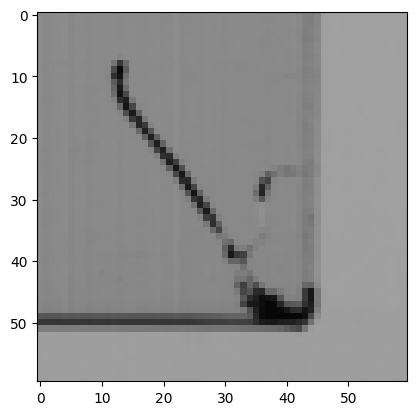

In [10]:
ex = resize_image(cv2.imread(images_dict['break'][0]), 'break', fixed_patch_size)
print(ex.shape)
plt.imshow(ex)

In [11]:
def preprocess_images(dict, index, size):
    for key in dict.keys():
        dict[key] = [img[:index] + '/' + img[index + 1:] for img in dict[key]]
        dict[key] = [aug for img in dict[key] for aug in augment_image(cv2.imread(img))]
        dict[key] = [resize_image(img, key, size) for img in dict[key]]
    
    return dict

In [12]:
def extend_target_classes(images_classes, n):
    target_classes = []
    for cls in images_classes:
        target_classes.extend([cls] * n)
    
    return target_classes

In [13]:
images_dict = preprocess_images(images_dict, 11, fixed_patch_size)

In [14]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    print('K:',K)

    for cls in K:
        datax_cls = np.random.permutation(datax[cls])[:(n_support + n_query)]
        sample.append(datax_cls)

    sample = np.array(sample)
    sample = torch.from_numpy(sample)

    sample = sample.permute(0, 1, 4, 2, 3)

    return({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query,
        'classes': list(K)
    })

In [15]:
sample_example = extract_sample(6, 4, 4, images_dict, images_classes)
sample_example['images'].shape, sample_example

K: ['dirt' 'point' 'bubble' 'scratch' 'mark' 'break']


(torch.Size([6, 8, 3, 60, 60]),
 {'images': tensor([[[[[142, 137, 146,  ..., 139, 140, 142],
             [141, 147, 138,  ..., 140, 138, 140],
             [141, 142, 142,  ..., 138, 140, 140],
             ...,
             [140, 142, 142,  ..., 139, 142, 141],
             [142, 140, 144,  ..., 141, 140, 139],
             [141, 141, 141,  ..., 136, 140, 145]],
  
            [[142, 137, 146,  ..., 139, 140, 142],
             [141, 147, 138,  ..., 140, 138, 140],
             [141, 142, 142,  ..., 138, 140, 140],
             ...,
             [140, 142, 142,  ..., 139, 142, 141],
             [142, 140, 144,  ..., 141, 140, 139],
             [141, 141, 141,  ..., 136, 140, 145]],
  
            [[142, 137, 146,  ..., 139, 140, 142],
             [141, 147, 138,  ..., 140, 138, 140],
             [141, 142, 142,  ..., 138, 140, 140],
             ...,
             [140, 142, 142,  ..., 139, 142, 141],
             [142, 140, 144,  ..., 141, 140, 139],
             [141, 141, 141, 

In [16]:
def display_sample(sample):
    sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

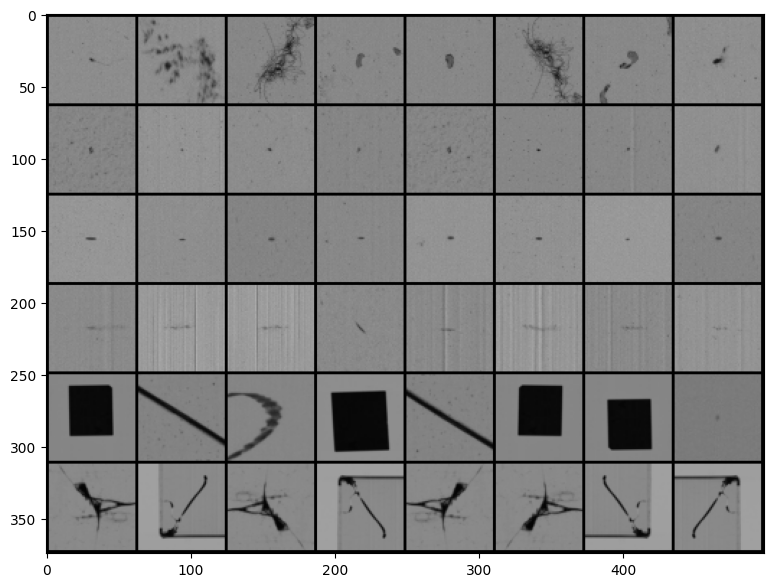

In [17]:
display_sample(sample_example['images'])

In [18]:
def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [19]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder#.cuda()

    def set_forward_loss(self, sample, accuracy_dict):
        sample_images = sample['images']#.cuda()
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        sample_labels = sample['classes']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds#.cuda()

        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                        x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
        
        z = self.encoder.forward(x.float())
        z_dim = z.size(-1) 
        z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        z_query = z[n_way*n_support:]

        dists = euclidean_dist(z_query, z_proto)

        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat.squeeze(), target_inds.squeeze()).float().mean()

        accuracy_tensor = []
        for row_target, row_predicted in zip(target_inds.squeeze(), y_hat.squeeze()):
            accuracy = (row_target == row_predicted).float().mean()
            accuracy_tensor.append([accuracy])
        accuracy_tensor = torch.tensor(accuracy_tensor)

        for accuracy, cls in zip(accuracy_tensor, sample_labels):
            if cls not in accuracy_dict:
                accuracy_dict[cls] = []
            accuracy_dict[cls].append(accuracy.item())

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat.squeeze(),
            'y_true': target_inds.squeeze()
        }, accuracy_dict

In [20]:
class Flatten(nn.Module):
    def __init__(self):
      super(Flatten, self).__init__()

    def forward(self, x):
      return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']

    def conv_block(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.MaxPool2d(2)
          )
    
    encoder = nn.Sequential(
      conv_block(x_dim[0], hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, z_dim),
      Flatten()
    )
      
    return ProtoNet(encoder)

In [21]:
def  split_train_test(data, percentage = 3/4):
    train_x = {}
    test_x = {}
    for key in data.keys():
        dim = len(data[key])
        train_x[key] = data[key][:int(len(data[key])*percentage)]
        test_x[key] = data[key][-int(dim - int(dim*percentage)):]

    train_y = []
    test_y = []
    for key in data.keys():
        dim = len(data[key])
        train_y.extend([key] * int(dim*percentage))
        test_y.extend([key] * int(dim - int(dim*percentage)))
    
    return train_x, train_y, test_x, test_y

# Train

In [22]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, epochs, episodes):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 

    accuracy_dict = {}
    final_accuracy = 0

    while epoch < epochs:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
            epoch_loss = running_loss / episodes
            epoch_acc = running_acc / episodes
            print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
            final_accuracy = epoch_acc
            epoch += 1
            scheduler.step()

    return accuracy_dict, final_accuracy

# Test

In [25]:
def test(model, test_x, test_y, n_way, n_support, n_query, episodes):
    running_loss = 0.0
    running_acc = 0.0

    accuracy_dict = {}

    for episode in tnrange(episodes):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output, accuracy_dict = model.set_forward_loss(sample, accuracy_dict)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / episodes
    avg_acc = running_acc / episodes
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

    return accuracy_dict, avg_acc

In [29]:
def train_test_pipeline(images_dict, split_percentage = 3/4, 
                        train_n_way = 3, train_n_support = 2, train_n_query = 1, train_epochs = 10, train_episodes = 50, 
                        test_n_way = 3, test_n_support = 1, test_n_query = 1, test_episodes = 50):
    
    train_x, train_y, test_x, test_y = split_train_test(images_dict, split_percentage)

    model = load_protonet_conv(
        x_dim=(3,fixed_patch_size,fixed_patch_size),
        hid_dim=64,
        z_dim=64,
    )

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    train_accuracy_dict, train_accuracy = train(model, optimizer, train_x, train_y, train_n_way, train_n_support, train_n_query, train_epochs, train_episodes)
    test_accuracy_dict, test_accuracy = test(model, test_x, test_y, test_n_way, test_n_support, test_n_query, test_episodes)

    return train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy

In [30]:
def plot_accuracies_dict(accuracies_dict, title):
    for dictionary in accuracies_dict:
        dictionary = dict(sorted(dictionary.items()))
        keys = list(dictionary.keys())
        values = list(dictionary.values())
        x = range(len(keys))
        values = [sum(sublist) / len(sublist) for sublist in values]
        print(values)
        plt.figure(figsize=(6, 4))
        plt.bar(x, values)
        plt.xticks(x, keys)
        plt.xticks(rotation=90)
        plt.ylim(0, 1)
        plt.xlabel('labels')
        plt.ylabel('recalls')
        plt.title(title)
        plt.show()

In [31]:
def plot_accuracies(increased_episodes, train_accuracies, test_accuracies):
    plt.plot(increased_episodes, train_accuracies, label='train_accuracies')
    plt.plot(increased_episodes, test_accuracies, label='test_accuracies')
    plt.ylim(0, 1)
    plt.xlabel('# of episodes')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('evolution of accuracy with # of episodes')
    plt.show()

In [32]:
def exec_multiple_episodes(episodes_list = [50, 100, 250, 500],
                            train_n_way = 6, train_n_support = 3, train_n_query = 3, train_epochs = 10, 
                            test_n_way = 6, test_n_support = 1, test_n_query = 1):
    train_accuracies_dict, test_accuracies_dict = [], []
    train_accuracies, test_accuracies = [], []

    for episodes in episodes_list:
        train_accuracy_dict, train_accuracy, test_accuracy_dict, test_accuracy = train_test_pipeline(images_dict, train_n_way = train_n_way, train_n_support = train_n_support, train_n_query = train_n_query, train_epochs = train_epochs, train_episodes = episodes, test_n_way = test_n_way, test_n_support = test_n_support, test_n_query = test_n_query, test_episodes = episodes)
        train_accuracies_dict.append(train_accuracy_dict)
        test_accuracies_dict.append(test_accuracy_dict)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies

# Training and testing on different number of episodes

In [33]:
images, images_classes, images_dict = extract_images('../data/img/')
images_dict = preprocess_images(images_dict, 11, fixed_patch_size)

In [34]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'bubble' 'scratch' 'dirt' 'mark' 'point']
Epoch 1 -- Loss: 1.1050 Acc: 0.0078
K: ['point' 'break' 'scratch' 'bubble' 'dirt' 'mark']
Epoch 2 -- Loss: 2.0840 Acc: 0.0156
K: ['dirt' 'scratch' 'bubble' 'mark' 'point' 'break']
Epoch 3 -- Loss: 2.8294 Acc: 0.0267
K: ['mark' 'scratch' 'point' 'break' 'bubble' 'dirt']
Epoch 4 -- Loss: 3.1000 Acc: 0.0389
K: ['mark' 'scratch' 'dirt' 'point' 'bubble' 'break']
Epoch 5 -- Loss: 3.7040 Acc: 0.0478
K: ['dirt' 'mark' 'point' 'bubble' 'break' 'scratch']
Epoch 6 -- Loss: 4.2784 Acc: 0.0600
K: ['bubble' 'break' 'point' 'dirt' 'mark' 'scratch']
Epoch 7 -- Loss: 5.4678 Acc: 0.0700
K: ['mark' 'bubble' 'dirt' 'point' 'break' 'scratch']
Epoch 8 -- Loss: 6.3988 Acc: 0.0811
K: ['break' 'point' 'bubble' 'mark' 'dirt' 'scratch']
Epoch 9 -- Loss: 6.9458 Acc: 0.0889
K: ['bubble' 'point' 'scratch' 'break' 'dirt' 'mark']
Epoch 10 -- Loss: 7.5803 Acc: 0.1033
K: ['mark' 'point' 'scratch' 'dirt' 'break' 'bubble']
Epoch 11 -- Loss: 8.3246 Acc: 0.1133
K: ['bre

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['dirt' 'bubble' 'mark' 'scratch' 'break' 'point']
K: ['bubble' 'scratch' 'mark' 'dirt' 'point' 'break']
K: ['dirt' 'break' 'scratch' 'bubble' 'mark' 'point']
K: ['dirt' 'scratch' 'bubble' 'point' 'break' 'mark']
K: ['point' 'bubble' 'mark' 'break' 'dirt' 'scratch']
K: ['dirt' 'mark' 'break' 'scratch' 'point' 'bubble']
K: ['break' 'scratch' 'mark' 'point' 'dirt' 'bubble']
K: ['point' 'mark' 'dirt' 'break' 'bubble' 'scratch']
K: ['scratch' 'mark' 'bubble' 'break' 'point' 'dirt']
K: ['point' 'mark' 'bubble' 'scratch' 'dirt' 'break']
K: ['scratch' 'dirt' 'point' 'break' 'bubble' 'mark']
K: ['break' 'mark' 'dirt' 'point' 'scratch' 'bubble']
K: ['mark' 'point' 'scratch' 'bubble' 'dirt' 'break']
K: ['scratch' 'break' 'point' 'bubble' 'mark' 'dirt']
K: ['scratch' 'mark' 'dirt' 'break' 'point' 'bubble']
K: ['break' 'scratch' 'point' 'bubble' 'mark' 'dirt']
K: ['point' 'dirt' 'scratch' 'break' 'mark' 'bubble']
K: ['dirt' 'scratch' 'break' 'point' 'mark' 'bubble']
K: ['bubble' 'point' 'scratc

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['point' 'break' 'scratch' 'mark' 'dirt' 'bubble']
Epoch 1 -- Loss: 0.7935 Acc: 0.0039
K: ['dirt' 'mark' 'break' 'point' 'bubble' 'scratch']
Epoch 2 -- Loss: 1.3952 Acc: 0.0078
K: ['point' 'bubble' 'scratch' 'mark' 'dirt' 'break']
Epoch 3 -- Loss: 1.5425 Acc: 0.0150
K: ['dirt' 'mark' 'point' 'break' 'scratch' 'bubble']
Epoch 4 -- Loss: 1.7398 Acc: 0.0206
K: ['dirt' 'point' 'scratch' 'break' 'mark' 'bubble']
Epoch 5 -- Loss: 1.7969 Acc: 0.0267
K: ['break' 'point' 'mark' 'dirt' 'bubble' 'scratch']
Epoch 6 -- Loss: 1.8979 Acc: 0.0328
K: ['break' 'point' 'dirt' 'bubble' 'scratch' 'mark']
Epoch 7 -- Loss: 2.0028 Acc: 0.0378
K: ['scratch' 'point' 'break' 'bubble' 'dirt' 'mark']
Epoch 8 -- Loss: 2.0290 Acc: 0.0461
K: ['break' 'dirt' 'mark' 'point' 'scratch' 'bubble']
Epoch 9 -- Loss: 2.0919 Acc: 0.0533
K: ['dirt' 'break' 'scratch' 'point' 'mark' 'bubble']
Epoch 10 -- Loss: 2.1905 Acc: 0.0600
K: ['scratch' 'mark' 'bubble' 'dirt' 'point' 'break']
Epoch 11 -- Loss: 2.2106 Acc: 0.0661
K: ['poi

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['bubble' 'mark' 'break' 'dirt' 'scratch' 'point']
K: ['dirt' 'bubble' 'scratch' 'mark' 'break' 'point']
K: ['scratch' 'point' 'break' 'mark' 'bubble' 'dirt']
K: ['point' 'mark' 'bubble' 'scratch' 'break' 'dirt']
K: ['bubble' 'point' 'break' 'dirt' 'mark' 'scratch']
K: ['bubble' 'break' 'point' 'mark' 'scratch' 'dirt']
K: ['break' 'bubble' 'scratch' 'dirt' 'point' 'mark']
K: ['point' 'scratch' 'break' 'dirt' 'mark' 'bubble']
K: ['mark' 'point' 'bubble' 'break' 'dirt' 'scratch']
K: ['mark' 'scratch' 'bubble' 'break' 'dirt' 'point']
K: ['dirt' 'scratch' 'point' 'mark' 'bubble' 'break']
K: ['mark' 'scratch' 'dirt' 'bubble' 'break' 'point']
K: ['scratch' 'point' 'dirt' 'mark' 'bubble' 'break']
K: ['mark' 'point' 'bubble' 'break' 'dirt' 'scratch']
K: ['dirt' 'bubble' 'scratch' 'mark' 'break' 'point']
K: ['dirt' 'point' 'scratch' 'break' 'mark' 'bubble']
K: ['scratch' 'break' 'point' 'mark' 'dirt' 'bubble']
K: ['bubble' 'point' 'dirt' 'scratch' 'mark' 'break']
K: ['bubble' 'scratch' 'brea

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['point' 'scratch' 'mark' 'break' 'dirt' 'bubble']
Epoch 1 -- Loss: 0.1562 Acc: 0.0018
K: ['scratch' 'bubble' 'break' 'dirt' 'point' 'mark']
Epoch 2 -- Loss: 0.2090 Acc: 0.0047
K: ['point' 'bubble' 'dirt' 'scratch' 'break' 'mark']
Epoch 3 -- Loss: 0.3435 Acc: 0.0069
K: ['point' 'mark' 'dirt' 'scratch' 'break' 'bubble']
Epoch 4 -- Loss: 0.3934 Acc: 0.0098
K: ['point' 'break' 'bubble' 'mark' 'scratch' 'dirt']
Epoch 5 -- Loss: 0.4589 Acc: 0.0120
K: ['dirt' 'point' 'bubble' 'break' 'scratch' 'mark']
Epoch 6 -- Loss: 0.5488 Acc: 0.0138
K: ['dirt' 'mark' 'break' 'point' 'scratch' 'bubble']
Epoch 7 -- Loss: 0.6452 Acc: 0.0164
K: ['mark' 'scratch' 'dirt' 'bubble' 'break' 'point']
Epoch 8 -- Loss: 0.7224 Acc: 0.0187
K: ['mark' 'break' 'scratch' 'dirt' 'point' 'bubble']
Epoch 9 -- Loss: 0.8135 Acc: 0.0213
K: ['scratch' 'break' 'dirt' 'bubble' 'point' 'mark']
Epoch 10 -- Loss: 0.8177 Acc: 0.0242
K: ['bubble' 'point' 'scratch' 'break' 'mark' 'dirt']
Epoch 11 -- Loss: 1.0023 Acc: 0.0260
K: ['bub

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['dirt' 'bubble' 'scratch' 'break' 'mark' 'point']
K: ['scratch' 'mark' 'break' 'point' 'dirt' 'bubble']
K: ['dirt' 'scratch' 'bubble' 'mark' 'break' 'point']
K: ['dirt' 'bubble' 'point' 'mark' 'break' 'scratch']
K: ['bubble' 'mark' 'break' 'dirt' 'scratch' 'point']
K: ['scratch' 'point' 'mark' 'break' 'dirt' 'bubble']
K: ['break' 'point' 'bubble' 'dirt' 'mark' 'scratch']
K: ['break' 'point' 'mark' 'scratch' 'dirt' 'bubble']
K: ['point' 'dirt' 'mark' 'break' 'scratch' 'bubble']
K: ['dirt' 'point' 'mark' 'break' 'scratch' 'bubble']
K: ['scratch' 'break' 'dirt' 'bubble' 'point' 'mark']
K: ['scratch' 'break' 'bubble' 'mark' 'dirt' 'point']
K: ['bubble' 'break' 'dirt' 'point' 'scratch' 'mark']
K: ['break' 'bubble' 'mark' 'point' 'scratch' 'dirt']
K: ['break' 'mark' 'point' 'dirt' 'bubble' 'scratch']
K: ['mark' 'point' 'scratch' 'bubble' 'break' 'dirt']
K: ['break' 'mark' 'dirt' 'scratch' 'bubble' 'point']
K: ['point' 'dirt' 'bubble' 'scratch' 'break' 'mark']
K: ['scratch' 'bubble' 'brea

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['bubble' 'point' 'scratch' 'mark' 'dirt' 'break']
Epoch 1 -- Loss: 0.0492 Acc: 0.0013
K: ['dirt' 'mark' 'scratch' 'break' 'bubble' 'point']
Epoch 2 -- Loss: 0.0684 Acc: 0.0029
K: ['dirt' 'break' 'scratch' 'point' 'mark' 'bubble']
Epoch 3 -- Loss: 0.1517 Acc: 0.0039
K: ['dirt' 'bubble' 'break' 'scratch' 'point' 'mark']
Epoch 4 -- Loss: 0.2121 Acc: 0.0050
K: ['scratch' 'point' 'break' 'dirt' 'mark' 'bubble']
Epoch 5 -- Loss: 0.2421 Acc: 0.0061
K: ['bubble' 'break' 'dirt' 'point' 'scratch' 'mark']
Epoch 6 -- Loss: 0.2434 Acc: 0.0078
K: ['bubble' 'break' 'dirt' 'scratch' 'point' 'mark']
Epoch 7 -- Loss: 0.2506 Acc: 0.0092
K: ['point' 'break' 'dirt' 'bubble' 'mark' 'scratch']
Epoch 8 -- Loss: 0.2879 Acc: 0.0104
K: ['point' 'dirt' 'break' 'bubble' 'scratch' 'mark']
Epoch 9 -- Loss: 0.3222 Acc: 0.0117
K: ['bubble' 'scratch' 'mark' 'point' 'break' 'dirt']
Epoch 10 -- Loss: 0.3546 Acc: 0.0126
K: ['bubble' 'scratch' 'break' 'dirt' 'mark' 'point']
Epoch 11 -- Loss: 0.4349 Acc: 0.0132
K: ['bre

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['bubble' 'break' 'dirt' 'scratch' 'point' 'mark']
K: ['break' 'scratch' 'dirt' 'point' 'bubble' 'mark']
K: ['break' 'point' 'bubble' 'scratch' 'mark' 'dirt']
K: ['bubble' 'break' 'mark' 'scratch' 'dirt' 'point']
K: ['scratch' 'bubble' 'mark' 'point' 'dirt' 'break']
K: ['mark' 'dirt' 'scratch' 'point' 'bubble' 'break']
K: ['point' 'break' 'dirt' 'mark' 'bubble' 'scratch']
K: ['scratch' 'dirt' 'break' 'point' 'bubble' 'mark']
K: ['bubble' 'scratch' 'dirt' 'break' 'point' 'mark']
K: ['point' 'scratch' 'break' 'dirt' 'bubble' 'mark']
K: ['dirt' 'scratch' 'mark' 'bubble' 'break' 'point']
K: ['mark' 'point' 'bubble' 'scratch' 'dirt' 'break']
K: ['dirt' 'bubble' 'mark' 'break' 'scratch' 'point']
K: ['dirt' 'break' 'mark' 'bubble' 'point' 'scratch']
K: ['bubble' 'scratch' 'point' 'mark' 'dirt' 'break']
K: ['scratch' 'bubble' 'break' 'dirt' 'point' 'mark']
K: ['point' 'break' 'dirt' 'mark' 'bubble' 'scratch']
K: ['bubble' 'dirt' 'break' 'mark' 'scratch' 'point']
K: ['mark' 'bubble' 'scratch

[0.8800000035762787, 0.4200000107288361, 0.4666666752099991, 0.5466666752099991, 0.4200000113248825, 0.613333340883255]


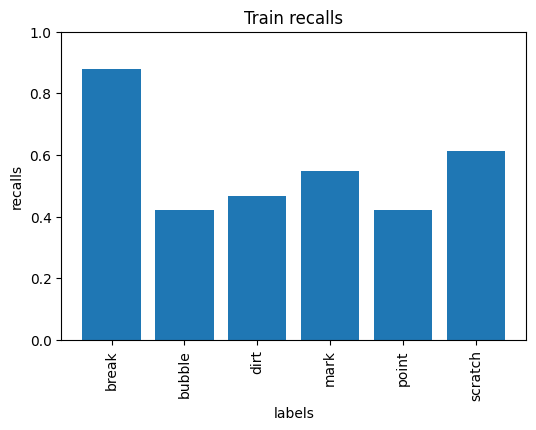

[0.7900000074505806, 0.5100000101327896, 0.39333334147930143, 0.4866666761040688, 0.500000010728836, 0.7500000065565109]


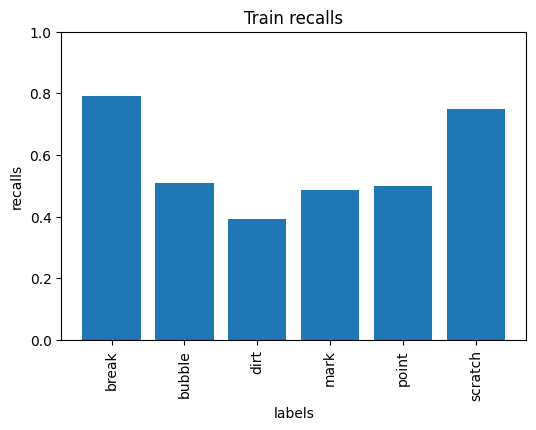

[0.8320000060796737, 0.5186666767597199, 0.5093333429098129, 0.5053333441019058, 0.4640000102519989, 0.8133333382606507]


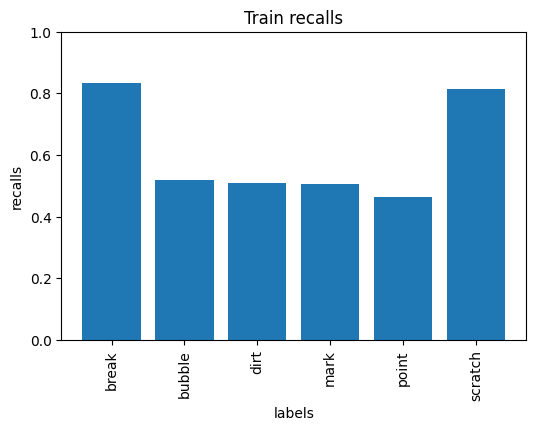

[0.7806666741371154, 0.4346666759252548, 0.4260000088214874, 0.6226666766405106, 0.47533334332704547, 0.7486666733026505]


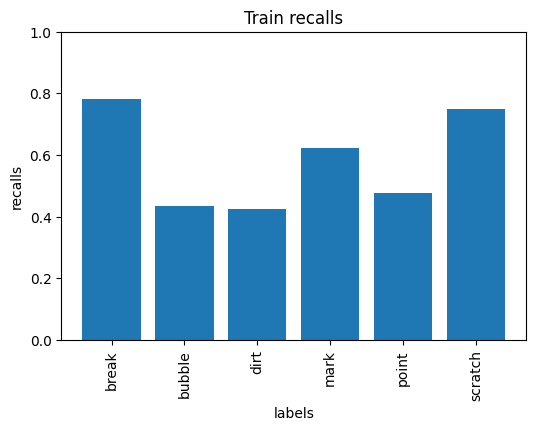

In [35]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

[0.94, 0.46, 0.1, 1.0, 0.64, 0.42]


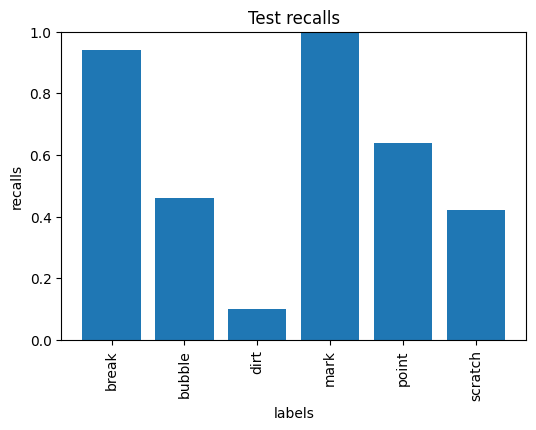

[1.0, 0.5, 0.2, 1.0, 0.6, 0.46]


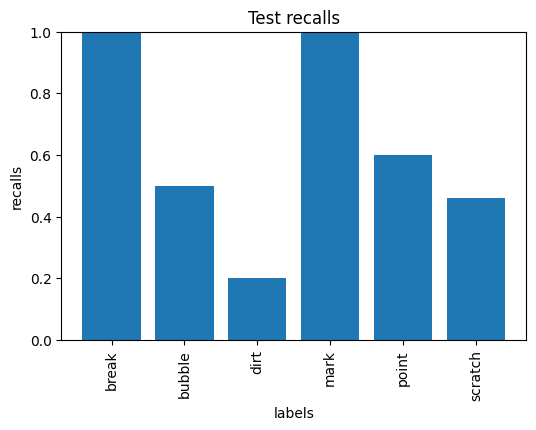

[0.94, 0.444, 0.224, 0.988, 0.636, 0.532]


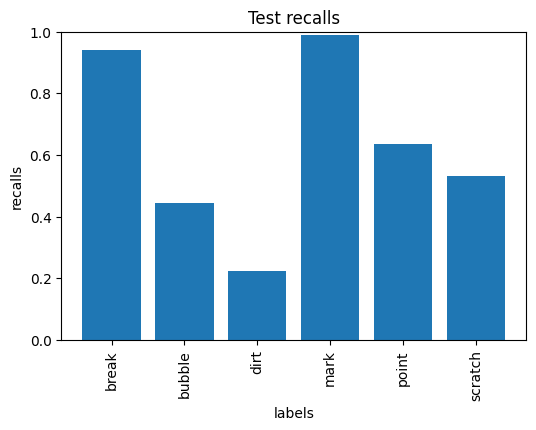

[1.0, 0.498, 0.29, 1.0, 0.552, 0.442]


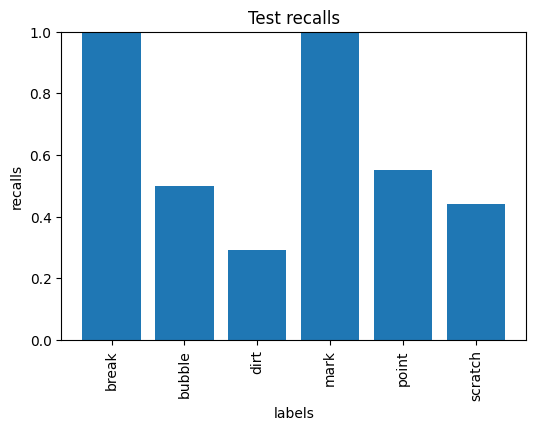

In [36]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

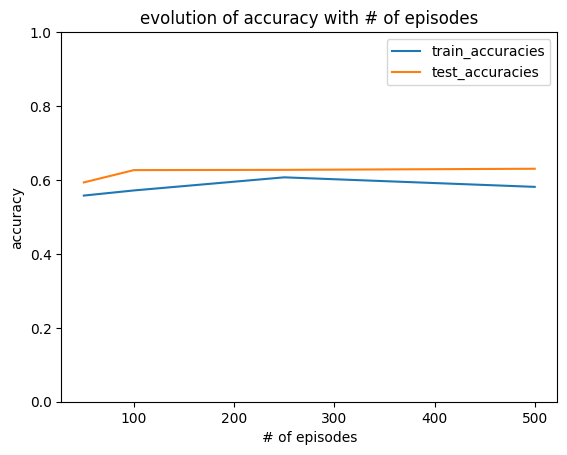

In [37]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using default dataset + background (opt_bckg)

In [38]:
images, images_classes, images_dict = extract_images('../data/views_opt_bckg/img/')
images_dict = preprocess_images(images_dict, 26, fixed_patch_size)

In [39]:
classes = set(images_classes)
classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

# Training and testing on different number of episodes

In [40]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'bubble' 'point' 'dirt' 'mark' 'background']
Epoch 1 -- Loss: 0.4247 Acc: 0.0089
K: ['mark' 'point' 'break' 'bubble' 'background' 'dirt']
Epoch 2 -- Loss: 0.5974 Acc: 0.0244
K: ['break' 'bubble' 'scratch' 'point' 'dirt' 'background']
Epoch 3 -- Loss: 0.8617 Acc: 0.0378
K: ['dirt' 'break' 'point' 'bubble' 'scratch' 'mark']
Epoch 4 -- Loss: 1.4169 Acc: 0.0478
K: ['break' 'background' 'point' 'mark' 'scratch' 'dirt']
Epoch 5 -- Loss: 2.2104 Acc: 0.0600
K: ['point' 'scratch' 'break' 'mark' 'bubble' 'background']
Epoch 6 -- Loss: 2.7248 Acc: 0.0711
K: ['scratch' 'mark' 'break' 'bubble' 'point' 'background']
Epoch 7 -- Loss: 3.0636 Acc: 0.0844
K: ['mark' 'bubble' 'point' 'break' 'dirt' 'scratch']
Epoch 8 -- Loss: 3.3269 Acc: 0.1000
K: ['mark' 'scratch' 'bubble' 'point' 'background' 'dirt']
Epoch 9 -- Loss: 4.2912 Acc: 0.1056
K: ['background' 'dirt' 'scratch' 'break' 'mark' 'point']
Epoch 10 -- Loss: 4.7087 Acc: 0.1156
K: ['point' 'dirt' 'scratch' 'mark' 'background' 'break']
Epoc

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['dirt' 'point' 'background' 'bubble' 'scratch' 'break']
K: ['mark' 'break' 'scratch' 'background' 'dirt' 'point']
K: ['background' 'bubble' 'break' 'mark' 'dirt' 'scratch']
K: ['dirt' 'scratch' 'mark' 'break' 'background' 'bubble']
K: ['mark' 'bubble' 'point' 'scratch' 'break' 'background']
K: ['dirt' 'background' 'break' 'scratch' 'mark' 'bubble']
K: ['break' 'mark' 'bubble' 'background' 'point' 'dirt']
K: ['break' 'point' 'scratch' 'mark' 'dirt' 'background']
K: ['background' 'mark' 'bubble' 'dirt' 'break' 'point']
K: ['bubble' 'dirt' 'mark' 'point' 'break' 'scratch']
K: ['dirt' 'background' 'scratch' 'break' 'mark' 'point']
K: ['dirt' 'break' 'bubble' 'mark' 'point' 'scratch']
K: ['background' 'dirt' 'break' 'scratch' 'mark' 'point']
K: ['bubble' 'background' 'dirt' 'break' 'point' 'mark']
K: ['mark' 'background' 'bubble' 'break' 'point' 'scratch']
K: ['dirt' 'background' 'scratch' 'break' 'mark' 'bubble']
K: ['bubble' 'dirt' 'scratch' 'background' 'break' 'mark']
K: ['break' 'p

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['dirt' 'bubble' 'background' 'break' 'scratch' 'mark']
Epoch 1 -- Loss: 0.7722 Acc: 0.0044
K: ['dirt' 'point' 'break' 'bubble' 'mark' 'background']
Epoch 2 -- Loss: 1.0508 Acc: 0.0100
K: ['bubble' 'dirt' 'background' 'point' 'mark' 'scratch']
Epoch 3 -- Loss: 1.3189 Acc: 0.0133
K: ['mark' 'bubble' 'background' 'break' 'scratch' 'dirt']
Epoch 4 -- Loss: 1.6959 Acc: 0.0178
K: ['background' 'mark' 'dirt' 'scratch' 'bubble' 'point']
Epoch 5 -- Loss: 1.9561 Acc: 0.0222
K: ['dirt' 'break' 'scratch' 'point' 'background' 'bubble']
Epoch 6 -- Loss: 2.1539 Acc: 0.0267
K: ['bubble' 'break' 'point' 'scratch' 'dirt' 'background']
Epoch 7 -- Loss: 2.5484 Acc: 0.0328
K: ['mark' 'background' 'dirt' 'scratch' 'break' 'bubble']
Epoch 8 -- Loss: 2.5749 Acc: 0.0411
K: ['scratch' 'point' 'mark' 'break' 'dirt' 'background']
Epoch 9 -- Loss: 2.6328 Acc: 0.0489
K: ['background' 'bubble' 'scratch' 'point' 'mark' 'dirt']
Epoch 10 -- Loss: 2.8114 Acc: 0.0539
K: ['mark' 'break' 'scratch' 'dirt' 'bubble' 'poin

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['point' 'background' 'dirt' 'scratch' 'bubble' 'break']
K: ['background' 'bubble' 'break' 'mark' 'dirt' 'point']
K: ['point' 'break' 'dirt' 'mark' 'background' 'bubble']
K: ['break' 'dirt' 'point' 'bubble' 'background' 'scratch']
K: ['point' 'break' 'dirt' 'mark' 'bubble' 'scratch']
K: ['dirt' 'scratch' 'mark' 'background' 'bubble' 'point']
K: ['dirt' 'background' 'point' 'bubble' 'mark' 'scratch']
K: ['scratch' 'break' 'point' 'bubble' 'background' 'mark']
K: ['scratch' 'dirt' 'background' 'point' 'bubble' 'break']
K: ['bubble' 'scratch' 'point' 'background' 'dirt' 'break']
K: ['bubble' 'dirt' 'break' 'background' 'point' 'scratch']
K: ['dirt' 'background' 'scratch' 'break' 'bubble' 'point']
K: ['bubble' 'break' 'mark' 'point' 'dirt' 'background']
K: ['mark' 'bubble' 'dirt' 'break' 'background' 'scratch']
K: ['bubble' 'mark' 'dirt' 'break' 'background' 'scratch']
K: ['mark' 'break' 'background' 'bubble' 'point' 'scratch']
K: ['point' 'bubble' 'mark' 'break' 'dirt' 'scratch']
K: ['

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['mark' 'bubble' 'dirt' 'background' 'scratch' 'break']
Epoch 1 -- Loss: 0.0179 Acc: 0.0033
K: ['scratch' 'dirt' 'break' 'background' 'mark' 'point']
Epoch 2 -- Loss: 1.1745 Acc: 0.0053
K: ['break' 'bubble' 'dirt' 'mark' 'scratch' 'background']
Epoch 3 -- Loss: 1.4366 Acc: 0.0069
K: ['scratch' 'point' 'dirt' 'background' 'bubble' 'mark']
Epoch 4 -- Loss: 1.6608 Acc: 0.0089
K: ['mark' 'dirt' 'point' 'bubble' 'background' 'break']
Epoch 5 -- Loss: 1.7640 Acc: 0.0104
K: ['point' 'background' 'dirt' 'scratch' 'break' 'mark']
Epoch 6 -- Loss: 1.9332 Acc: 0.0124
K: ['background' 'bubble' 'dirt' 'mark' 'scratch' 'point']
Epoch 7 -- Loss: 2.0241 Acc: 0.0153
K: ['point' 'bubble' 'mark' 'dirt' 'break' 'background']
Epoch 8 -- Loss: 2.1257 Acc: 0.0171
K: ['scratch' 'bubble' 'break' 'mark' 'point' 'background']
Epoch 9 -- Loss: 2.1974 Acc: 0.0189
K: ['point' 'bubble' 'background' 'mark' 'scratch' 'break']
Epoch 10 -- Loss: 2.2161 Acc: 0.0216
K: ['dirt' 'scratch' 'break' 'background' 'mark' 'poi

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['point' 'break' 'scratch' 'bubble' 'dirt' 'background']
K: ['dirt' 'bubble' 'point' 'background' 'scratch' 'mark']
K: ['scratch' 'break' 'background' 'point' 'mark' 'bubble']
K: ['dirt' 'break' 'background' 'mark' 'point' 'bubble']
K: ['mark' 'background' 'point' 'scratch' 'break' 'dirt']
K: ['dirt' 'bubble' 'scratch' 'break' 'background' 'point']
K: ['mark' 'scratch' 'background' 'break' 'point' 'dirt']
K: ['mark' 'dirt' 'scratch' 'bubble' 'background' 'break']
K: ['bubble' 'mark' 'break' 'background' 'point' 'scratch']
K: ['break' 'mark' 'point' 'scratch' 'bubble' 'background']
K: ['background' 'scratch' 'dirt' 'point' 'break' 'bubble']
K: ['point' 'background' 'break' 'bubble' 'scratch' 'mark']
K: ['bubble' 'background' 'break' 'mark' 'dirt' 'scratch']
K: ['background' 'mark' 'bubble' 'dirt' 'break' 'point']
K: ['scratch' 'break' 'mark' 'dirt' 'bubble' 'background']
K: ['break' 'dirt' 'mark' 'bubble' 'background' 'point']
K: ['bubble' 'mark' 'break' 'point' 'background' 'scratch

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['bubble' 'mark' 'scratch' 'background' 'dirt' 'point']
Epoch 1 -- Loss: 0.1710 Acc: 0.0012
K: ['point' 'break' 'dirt' 'bubble' 'scratch' 'background']
Epoch 2 -- Loss: 0.2572 Acc: 0.0024
K: ['mark' 'scratch' 'bubble' 'background' 'point' 'dirt']
Epoch 3 -- Loss: 0.2926 Acc: 0.0037
K: ['point' 'dirt' 'background' 'scratch' 'break' 'mark']
Epoch 4 -- Loss: 0.3253 Acc: 0.0049
K: ['point' 'scratch' 'mark' 'dirt' 'break' 'bubble']
Epoch 5 -- Loss: 0.3572 Acc: 0.0058
K: ['background' 'mark' 'bubble' 'break' 'point' 'dirt']
Epoch 6 -- Loss: 0.3892 Acc: 0.0069
K: ['break' 'dirt' 'background' 'point' 'mark' 'scratch']
Epoch 7 -- Loss: 0.3978 Acc: 0.0079
K: ['point' 'background' 'dirt' 'bubble' 'scratch' 'mark']
Epoch 8 -- Loss: 0.4362 Acc: 0.0089
K: ['background' 'point' 'bubble' 'dirt' 'scratch' 'break']
Epoch 9 -- Loss: 0.4755 Acc: 0.0101
K: ['break' 'point' 'bubble' 'background' 'mark' 'scratch']
Epoch 10 -- Loss: 0.5081 Acc: 0.0112
K: ['bubble' 'scratch' 'mark' 'background' 'dirt' 'poin

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['mark' 'dirt' 'bubble' 'background' 'scratch' 'break']
K: ['scratch' 'background' 'mark' 'point' 'bubble' 'dirt']
K: ['dirt' 'break' 'point' 'scratch' 'background' 'mark']
K: ['scratch' 'point' 'dirt' 'mark' 'break' 'bubble']
K: ['bubble' 'break' 'mark' 'scratch' 'dirt' 'point']
K: ['dirt' 'point' 'scratch' 'break' 'bubble' 'mark']
K: ['bubble' 'break' 'background' 'dirt' 'scratch' 'mark']
K: ['bubble' 'dirt' 'break' 'mark' 'point' 'scratch']
K: ['background' 'bubble' 'point' 'break' 'scratch' 'mark']
K: ['point' 'break' 'mark' 'bubble' 'dirt' 'background']
K: ['bubble' 'point' 'background' 'dirt' 'scratch' 'mark']
K: ['dirt' 'point' 'bubble' 'mark' 'background' 'scratch']
K: ['break' 'mark' 'dirt' 'bubble' 'scratch' 'point']
K: ['point' 'bubble' 'dirt' 'break' 'mark' 'background']
K: ['background' 'break' 'bubble' 'scratch' 'point' 'dirt']
K: ['mark' 'dirt' 'break' 'bubble' 'scratch' 'background']
K: ['dirt' 'bubble' 'scratch' 'point' 'mark' 'break']
K: ['bubble' 'dirt' 'mark' 'ba

[0.4796748023207595, 0.8861788678460005, 0.4592592669857873, 0.5634920731896446, 0.6814814892080095, 0.46969697827642615, 0.5714285799435207]


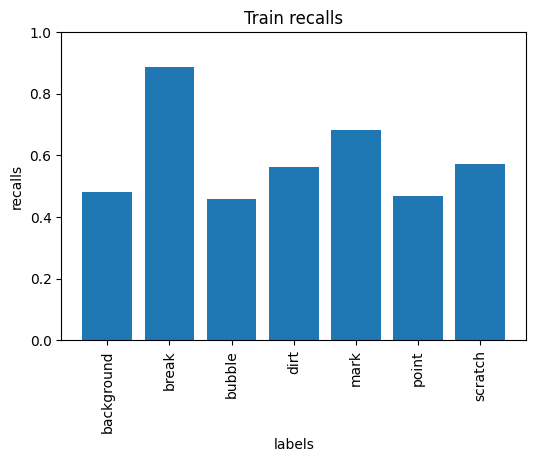

[0.7196969728578221, 0.7601626071988082, 0.49621213193644176, 0.5529411859372083, 0.6475095837965779, 0.44061303652566053, 0.5702811339533472]


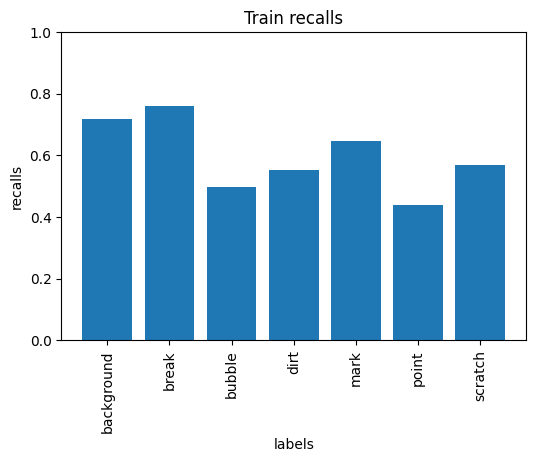

[0.6025039184261376, 0.7108067041390562, 0.4708737958114124, 0.493527517301365, 0.6546546620828612, 0.5422222329510583, 0.5279106944086449]


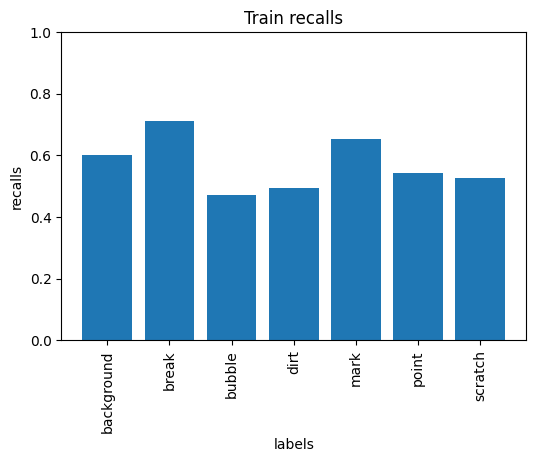

[0.5992424299771135, 0.6612529094285589, 0.4057632492524441, 0.5054517231672724, 0.6357142944421087, 0.45707657635903415, 0.4676145418984065]


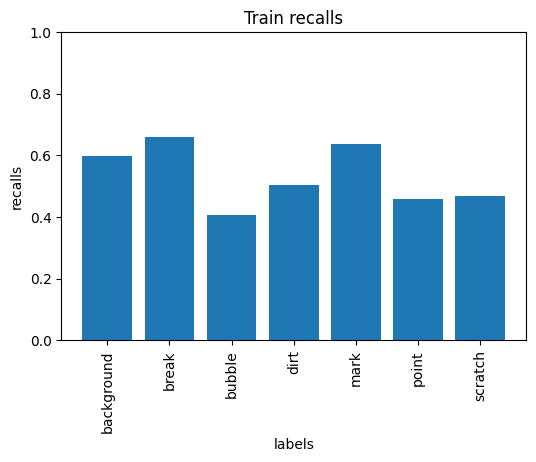

In [41]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

[1.0, 1.0, 0.43902439024390244, 0.2857142857142857, 1.0, 0.7105263157894737, 0.37209302325581395]


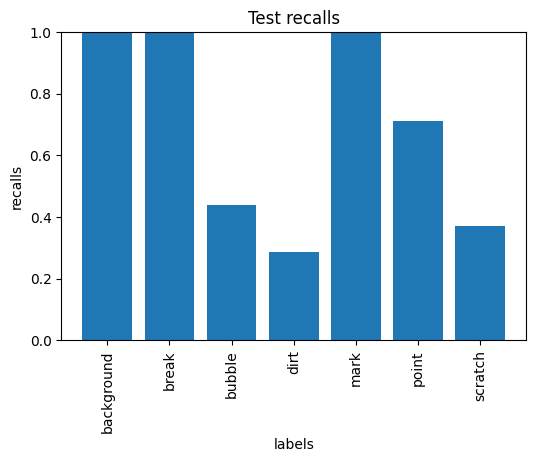

[1.0, 0.6511627906976745, 0.3181818181818182, 0.1566265060240964, 1.0, 0.7931034482758621, 0.4117647058823529]


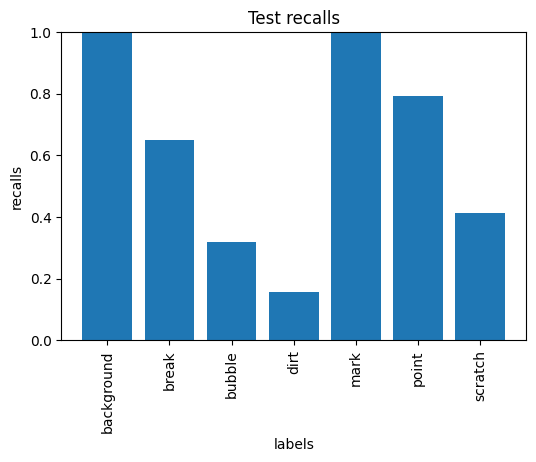

[0.9954954954954955, 1.0, 0.3878504672897196, 0.1926605504587156, 1.0, 0.7023255813953488, 0.35467980295566504]


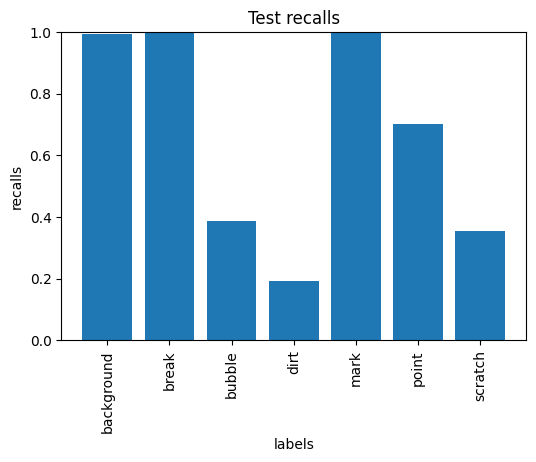

[1.0, 0.9791666666666666, 0.4135514018691589, 0.17050691244239632, 1.0, 0.6819221967963387, 0.4117647058823529]


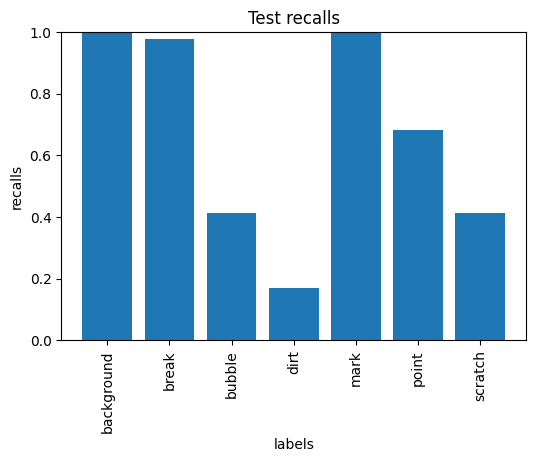

In [42]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

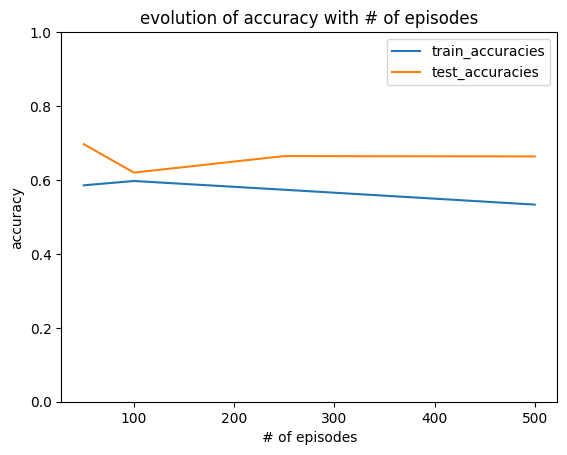

In [43]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus dataset (general classes)

In [44]:
images, images_classes, images_dict = extract_images('../data/views_qplus/img/')
images_dict = preprocess_images(images_dict, 23, fixed_patch_size)

In [45]:
classes = set(images_classes)
classes

{'altro',
 'break',
 'bubble',
 'coating',
 'dirt',
 'dust',
 'glass',
 'halo',
 'mark',
 'point',
 'scratch'}

# Training and testing on different number of episodes

In [46]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['altro' 'bubble' 'point' 'dirt' 'dust' 'break']
Epoch 1 -- Loss: 1.6476 Acc: 0.0133
K: ['scratch' 'altro' 'halo' 'glass' 'dust' 'coating']
Epoch 2 -- Loss: 3.0830 Acc: 0.0233
K: ['scratch' 'altro' 'dust' 'halo' 'coating' 'point']
Epoch 3 -- Loss: 3.2442 Acc: 0.0356
K: ['coating' 'dust' 'mark' 'bubble' 'scratch' 'halo']
Epoch 4 -- Loss: 4.2249 Acc: 0.0444
K: ['bubble' 'halo' 'mark' 'break' 'glass' 'dust']
Epoch 5 -- Loss: 4.4815 Acc: 0.0567
K: ['altro' 'halo' 'scratch' 'glass' 'dust' 'dirt']
Epoch 6 -- Loss: 4.9342 Acc: 0.0678
K: ['break' 'glass' 'bubble' 'dirt' 'point' 'mark']
Epoch 7 -- Loss: 5.2118 Acc: 0.0811
K: ['bubble' 'point' 'scratch' 'dust' 'mark' 'glass']
Epoch 8 -- Loss: 5.5761 Acc: 0.0867
K: ['dirt' 'dust' 'bubble' 'altro' 'point' 'break']
Epoch 9 -- Loss: 5.9040 Acc: 0.0989
K: ['halo' 'altro' 'dust' 'mark' 'coating' 'glass']
Epoch 10 -- Loss: 6.2508 Acc: 0.1111
K: ['dirt' 'altro' 'scratch' 'glass' 'point' 'break']
Epoch 11 -- Loss: 6.9547 Acc: 0.1222
K: ['coating' 'mar

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'scratch' 'coating' 'mark' 'altro' 'bubble']
K: ['coating' 'halo' 'altro' 'glass' 'break' 'mark']
K: ['bubble' 'point' 'scratch' 'dust' 'dirt' 'coating']
K: ['break' 'halo' 'scratch' 'point' 'dust' 'coating']
K: ['bubble' 'break' 'dust' 'scratch' 'altro' 'coating']
K: ['mark' 'altro' 'scratch' 'bubble' 'dirt' 'break']
K: ['point' 'dust' 'scratch' 'break' 'bubble' 'mark']
K: ['point' 'scratch' 'dirt' 'altro' 'glass' 'break']
K: ['mark' 'coating' 'scratch' 'dust' 'altro' 'break']
K: ['coating' 'halo' 'glass' 'scratch' 'altro' 'dirt']
K: ['break' 'dirt' 'dust' 'scratch' 'coating' 'bubble']
K: ['scratch' 'halo' 'dirt' 'glass' 'altro' 'point']
K: ['break' 'dirt' 'halo' 'point' 'bubble' 'coating']
K: ['glass' 'point' 'break' 'bubble' 'coating' 'scratch']
K: ['mark' 'altro' 'dirt' 'coating' 'break' 'dust']
K: ['glass' 'altro' 'mark' 'coating' 'dirt' 'halo']
K: ['coating' 'halo' 'point' 'scratch' 'bubble' 'break']
K: ['point' 'halo' 'bubble' 'glass' 'dirt' 'mark']
K: ['glass' 'altr

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['halo' 'altro' 'break' 'dust' 'point' 'scratch']
Epoch 1 -- Loss: 0.5673 Acc: 0.0056
K: ['dust' 'point' 'break' 'bubble' 'halo' 'scratch']
Epoch 2 -- Loss: 0.7753 Acc: 0.0106
K: ['point' 'dirt' 'dust' 'break' 'coating' 'scratch']
Epoch 3 -- Loss: 1.0213 Acc: 0.0156
K: ['altro' 'halo' 'bubble' 'point' 'glass' 'dirt']
Epoch 4 -- Loss: 1.1677 Acc: 0.0194
K: ['coating' 'dust' 'dirt' 'halo' 'glass' 'mark']
Epoch 5 -- Loss: 1.4884 Acc: 0.0244
K: ['dirt' 'mark' 'glass' 'dust' 'break' 'coating']
Epoch 6 -- Loss: 1.7211 Acc: 0.0300
K: ['dust' 'dirt' 'altro' 'mark' 'bubble' 'halo']
Epoch 7 -- Loss: 1.7831 Acc: 0.0361
K: ['bubble' 'scratch' 'altro' 'break' 'point' 'halo']
Epoch 8 -- Loss: 2.0008 Acc: 0.0417
K: ['bubble' 'coating' 'glass' 'dirt' 'point' 'dust']
Epoch 9 -- Loss: 2.5346 Acc: 0.0472
K: ['mark' 'coating' 'scratch' 'glass' 'break' 'dirt']
Epoch 10 -- Loss: 2.8600 Acc: 0.0544
K: ['coating' 'halo' 'mark' 'bubble' 'dirt' 'altro']
Epoch 11 -- Loss: 3.1648 Acc: 0.0578
K: ['break' 'bubbl

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['halo' 'mark' 'break' 'coating' 'scratch' 'dust']
K: ['dust' 'bubble' 'break' 'dirt' 'mark' 'point']
K: ['break' 'altro' 'halo' 'dust' 'coating' 'mark']
K: ['point' 'dust' 'coating' 'altro' 'glass' 'scratch']
K: ['dust' 'scratch' 'dirt' 'bubble' 'glass' 'break']
K: ['coating' 'break' 'halo' 'dust' 'bubble' 'mark']
K: ['bubble' 'dust' 'break' 'mark' 'glass' 'altro']
K: ['dust' 'break' 'glass' 'coating' 'dirt' 'bubble']
K: ['point' 'halo' 'dirt' 'glass' 'coating' 'scratch']
K: ['coating' 'glass' 'dirt' 'scratch' 'bubble' 'point']
K: ['dirt' 'dust' 'halo' 'coating' 'break' 'mark']
K: ['dirt' 'glass' 'dust' 'point' 'break' 'mark']
K: ['dust' 'altro' 'scratch' 'mark' 'coating' 'bubble']
K: ['dust' 'mark' 'point' 'bubble' 'halo' 'altro']
K: ['dust' 'dirt' 'scratch' 'glass' 'break' 'bubble']
K: ['glass' 'dirt' 'altro' 'break' 'dust' 'scratch']
K: ['dirt' 'halo' 'scratch' 'break' 'glass' 'mark']
K: ['mark' 'coating' 'bubble' 'altro' 'scratch' 'break']
K: ['scratch' 'glass' 'halo' 'break' '

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['altro' 'scratch' 'mark' 'dust' 'glass' 'halo']
Epoch 1 -- Loss: 0.2724 Acc: 0.0022
K: ['point' 'break' 'scratch' 'altro' 'bubble' 'glass']
Epoch 2 -- Loss: 0.3968 Acc: 0.0038
K: ['point' 'scratch' 'halo' 'altro' 'mark' 'bubble']
Epoch 3 -- Loss: 0.5597 Acc: 0.0051
K: ['halo' 'altro' 'dirt' 'bubble' 'scratch' 'glass']
Epoch 4 -- Loss: 0.6173 Acc: 0.0071
K: ['mark' 'bubble' 'point' 'scratch' 'dust' 'glass']
Epoch 5 -- Loss: 0.8005 Acc: 0.0091
K: ['break' 'coating' 'altro' 'bubble' 'halo' 'point']
Epoch 6 -- Loss: 0.8142 Acc: 0.0118
K: ['break' 'dust' 'mark' 'dirt' 'bubble' 'coating']
Epoch 7 -- Loss: 0.8506 Acc: 0.0149
K: ['break' 'coating' 'mark' 'point' 'halo' 'altro']
Epoch 8 -- Loss: 0.9344 Acc: 0.0178
K: ['halo' 'dirt' 'bubble' 'dust' 'altro' 'break']
Epoch 9 -- Loss: 0.9850 Acc: 0.0204
K: ['altro' 'dust' 'break' 'bubble' 'coating' 'dirt']
Epoch 10 -- Loss: 1.0221 Acc: 0.0229
K: ['dirt' 'coating' 'point' 'dust' 'break' 'scratch']
Epoch 11 -- Loss: 1.0566 Acc: 0.0258
K: ['mark' 

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['glass' 'bubble' 'scratch' 'dust' 'break' 'mark']
K: ['bubble' 'glass' 'coating' 'halo' 'altro' 'break']
K: ['break' 'glass' 'point' 'mark' 'dirt' 'halo']
K: ['dirt' 'point' 'altro' 'mark' 'scratch' 'halo']
K: ['scratch' 'altro' 'dirt' 'mark' 'dust' 'halo']
K: ['glass' 'dust' 'altro' 'coating' 'mark' 'bubble']
K: ['altro' 'glass' 'point' 'mark' 'coating' 'dust']
K: ['dust' 'glass' 'point' 'mark' 'halo' 'break']
K: ['coating' 'point' 'bubble' 'glass' 'dust' 'mark']
K: ['dust' 'scratch' 'bubble' 'altro' 'point' 'glass']
K: ['halo' 'dust' 'coating' 'dirt' 'mark' 'glass']
K: ['dust' 'mark' 'break' 'halo' 'scratch' 'point']
K: ['bubble' 'break' 'dirt' 'coating' 'mark' 'halo']
K: ['halo' 'mark' 'bubble' 'altro' 'coating' 'glass']
K: ['coating' 'halo' 'dust' 'bubble' 'glass' 'dirt']
K: ['mark' 'dust' 'bubble' 'coating' 'break' 'altro']
K: ['glass' 'dirt' 'point' 'altro' 'dust' 'break']
K: ['bubble' 'coating' 'halo' 'glass' 'break' 'scratch']
K: ['point' 'dust' 'altro' 'mark' 'bubble' 'hal

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['coating' 'scratch' 'halo' 'glass' 'dust' 'bubble']
Epoch 1 -- Loss: 0.0553 Acc: 0.0011
K: ['mark' 'altro' 'bubble' 'glass' 'point' 'break']
Epoch 2 -- Loss: 0.1732 Acc: 0.0022
K: ['halo' 'glass' 'altro' 'coating' 'dust' 'break']
Epoch 3 -- Loss: 0.2672 Acc: 0.0033
K: ['glass' 'altro' 'break' 'bubble' 'point' 'scratch']
Epoch 4 -- Loss: 0.4007 Acc: 0.0044
K: ['dust' 'halo' 'dirt' 'glass' 'coating' 'altro']
Epoch 5 -- Loss: 0.4476 Acc: 0.0058
K: ['altro' 'scratch' 'break' 'glass' 'bubble' 'dirt']
Epoch 6 -- Loss: 0.5336 Acc: 0.0069
K: ['dust' 'point' 'mark' 'break' 'dirt' 'coating']
Epoch 7 -- Loss: 0.6629 Acc: 0.0080
K: ['break' 'mark' 'glass' 'dirt' 'point' 'scratch']
Epoch 8 -- Loss: 0.8733 Acc: 0.0092
K: ['coating' 'dust' 'point' 'break' 'altro' 'mark']
Epoch 9 -- Loss: 0.9675 Acc: 0.0104
K: ['break' 'altro' 'dust' 'mark' 'glass' 'bubble']
Epoch 10 -- Loss: 1.0796 Acc: 0.0119
K: ['altro' 'glass' 'bubble' 'point' 'break' 'dust']
Epoch 11 -- Loss: 1.1264 Acc: 0.0134
K: ['scratch' 

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['dust' 'halo' 'altro' 'dirt' 'coating' 'break']
K: ['point' 'scratch' 'mark' 'altro' 'dirt' 'bubble']
K: ['dirt' 'coating' 'glass' 'point' 'scratch' 'bubble']
K: ['point' 'dirt' 'halo' 'bubble' 'scratch' 'coating']
K: ['point' 'bubble' 'scratch' 'halo' 'break' 'dust']
K: ['halo' 'dust' 'bubble' 'glass' 'scratch' 'altro']
K: ['point' 'coating' 'scratch' 'dust' 'mark' 'break']
K: ['altro' 'dirt' 'coating' 'break' 'glass' 'bubble']
K: ['break' 'altro' 'dirt' 'coating' 'scratch' 'halo']
K: ['scratch' 'dirt' 'point' 'break' 'coating' 'altro']
K: ['dust' 'point' 'coating' 'bubble' 'dirt' 'mark']
K: ['break' 'coating' 'altro' 'point' 'bubble' 'halo']
K: ['break' 'glass' 'mark' 'bubble' 'point' 'dust']
K: ['scratch' 'mark' 'dirt' 'coating' 'altro' 'dust']
K: ['altro' 'coating' 'scratch' 'glass' 'mark' 'bubble']
K: ['bubble' 'point' 'coating' 'break' 'scratch' 'dirt']
K: ['bubble' 'coating' 'dirt' 'mark' 'point' 'glass']
K: ['glass' 'halo' 'altro' 'coating' 'point' 'break']
K: ['glass' 'mar

[0.3055555621782939, 0.6321839124991976, 0.5444444547096888, 0.946666669845581, 0.5802469220426347, 0.511111119389534, 0.690476197217192, 0.6428571535008294, 0.6811594315197157, 0.333333341514363, 0.27272728085517883]


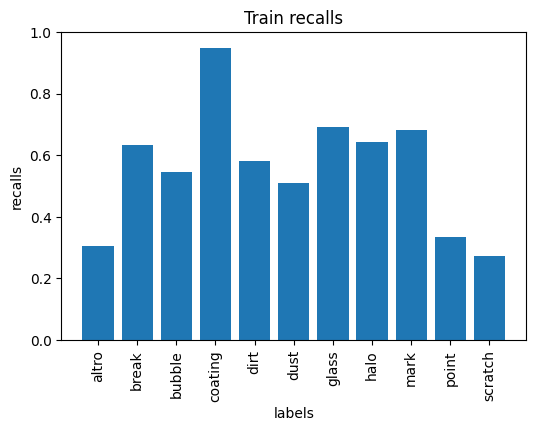

[0.28000000715255735, 0.6089743627951696, 0.47272728248076007, 0.9215686315414953, 0.4408602233855955, 0.5114942609236158, 0.7466666758060455, 0.6792452903288715, 0.5816993561445498, 0.2611111178994179, 0.3103448358075372]


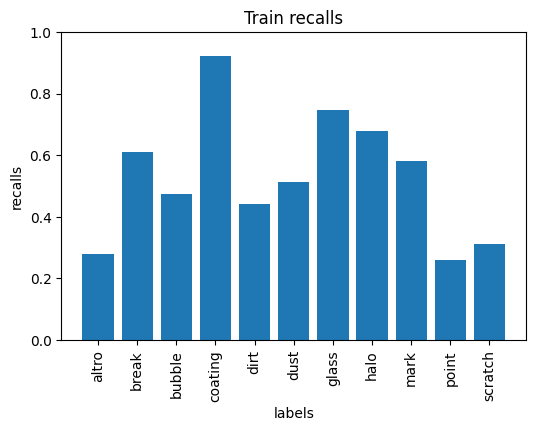

[0.4217687170116269, 0.8369829713428107, 0.46517413876839536, 0.8820512865598386, 0.5155875393383794, 0.5170603758237493, 0.8690476247242519, 0.7935323448323491, 0.5037037138585692, 0.36130536936379815, 0.3084577188562991]


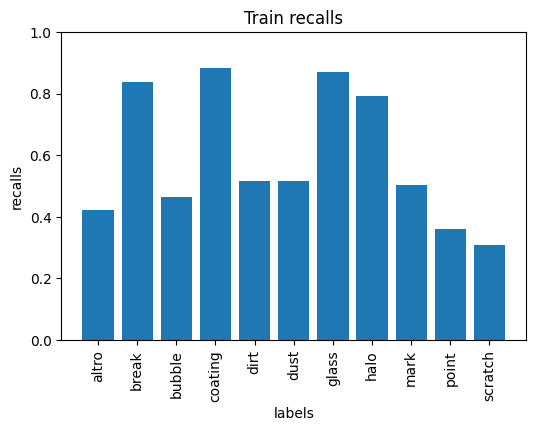

[0.2529976080647475, 0.7693194985183465, 0.43816255417392447, 0.8761904814413616, 0.514705891994869, 0.5069708566928545, 0.7797408794767022, 0.826199745389738, 0.5985130212342429, 0.35632184695923463, 0.298113214969635]


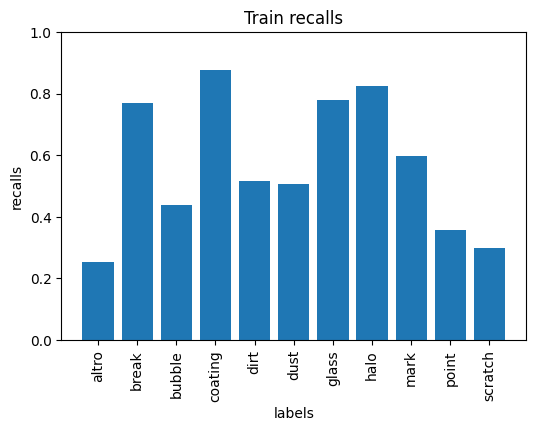

In [47]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

[0.5517241379310345, 0.0, 0.9642857142857143, 0.9142857142857143, 0.6428571428571429, 0.6666666666666666, 0.27586206896551724, 0.3333333333333333, 0.5789473684210527, 0.36666666666666664, 0.45714285714285713]


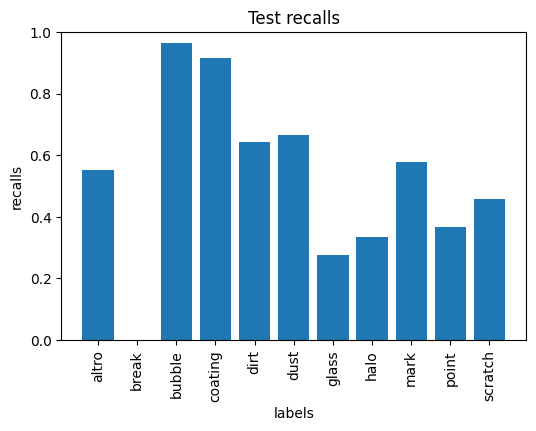

[0.5777777777777777, 0.0, 0.8867924528301887, 0.9047619047619048, 0.35185185185185186, 0.8, 0.35714285714285715, 0.24528301886792453, 0.5882352941176471, 0.43137254901960786, 0.4666666666666667]


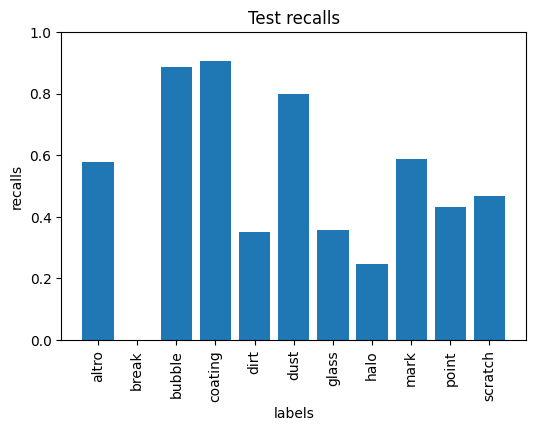

[0.3971631205673759, 0.0, 0.9296875, 0.8424657534246576, 0.5, 0.7205882352941176, 0.16546762589928057, 0.3282442748091603, 0.5223880597014925, 0.3875968992248062, 0.47761194029850745]


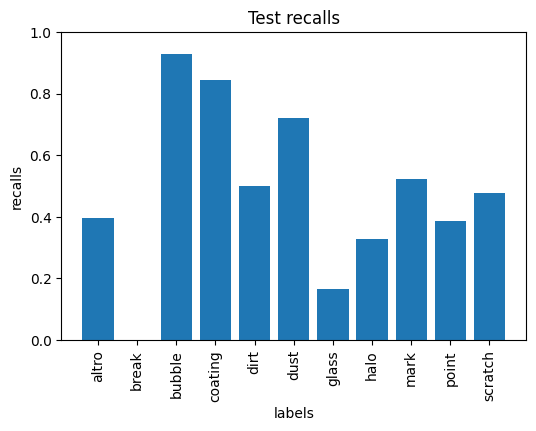

[0.4659498207885305, 0.003663003663003663, 0.9473684210526315, 0.8854961832061069, 0.5591397849462365, 0.8487084870848709, 0.3663003663003663, 0.36900369003690037, 0.5719557195571956, 0.3132075471698113, 0.5092250922509225]


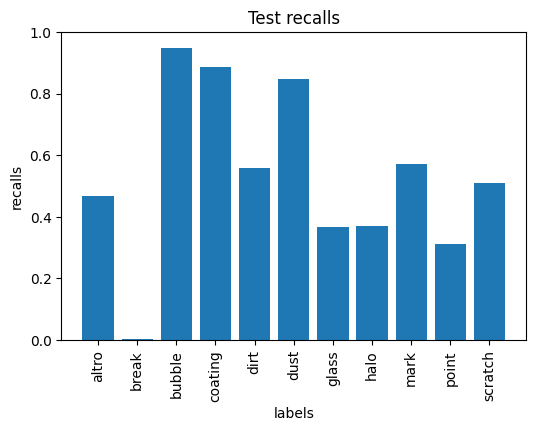

In [48]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

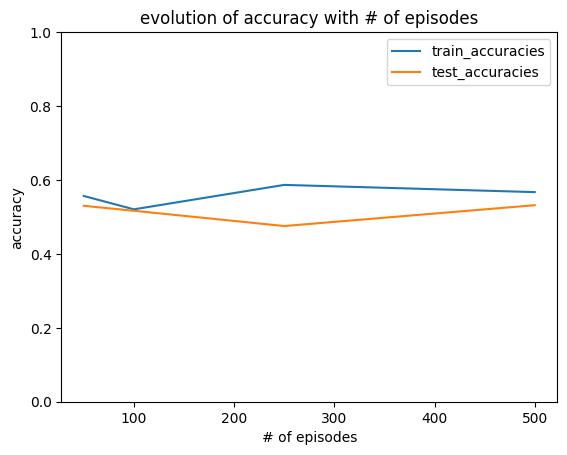

In [49]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus dataset (detailed classes)

In [50]:
images, images_classes, images_dict = extract_images('../data/views_qplus/img/', '_did_')
images_dict = preprocess_images(images_dict, 23, fixed_patch_size)

In [51]:
classes = set(images_classes)
classes

{'altro',
 'break',
 'bubble',
 'bubble_hole',
 'coating',
 'dirt',
 'dirt_halo',
 'dust',
 'glass_id',
 'halo',
 'mark',
 'point',
 'scratch_heavy',
 'scratch_light',
 'scratch_multi'}

# Training and testing on different number of episodes

In [52]:
episodes_list, train_accuracies_dict, test_accuracies_dict, train_accuracies, test_accuracies = exec_multiple_episodes()

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble_hole' 'dirt_halo' 'glass_id' 'mark' 'break' 'scratch_multi']
Epoch 1 -- Loss: 0.1024 Acc: 0.0167
K: ['bubble_hole' 'dirt' 'break' 'altro' 'bubble' 'dust']
Epoch 2 -- Loss: 0.6047 Acc: 0.0278
K: ['scratch_heavy' 'dirt' 'scratch_multi' 'break' 'glass_id' 'coating']
Epoch 3 -- Loss: 0.8082 Acc: 0.0422
K: ['point' 'mark' 'dirt' 'scratch_light' 'coating' 'dirt_halo']
Epoch 4 -- Loss: 1.1697 Acc: 0.0533
K: ['coating' 'glass_id' 'break' 'bubble' 'bubble_hole' 'scratch_multi']
Epoch 5 -- Loss: 1.2953 Acc: 0.0689
K: ['scratch_heavy' 'scratch_light' 'bubble_hole' 'bubble' 'halo' 'dirt']
Epoch 6 -- Loss: 1.6678 Acc: 0.0822
K: ['glass_id' 'scratch_multi' 'bubble_hole' 'coating' 'altro' 'dirt_halo']
Epoch 7 -- Loss: 2.2732 Acc: 0.0911
K: ['scratch_multi' 'point' 'coating' 'mark' 'dirt_halo' 'halo']
Epoch 8 -- Loss: 2.5161 Acc: 0.1067
K: ['coating' 'altro' 'bubble_hole' 'scratch_heavy' 'scratch_multi'
 'dirt_halo']
Epoch 9 -- Loss: 3.0161 Acc: 0.1122
K: ['scratch_heavy' 'coating' 'dirt' 

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['bubble' 'glass_id' 'altro' 'scratch_multi' 'mark' 'coating']
K: ['mark' 'halo' 'dirt' 'altro' 'dirt_halo' 'scratch_heavy']
K: ['dust' 'scratch_light' 'dirt' 'bubble' 'coating' 'glass_id']
K: ['coating' 'dirt' 'bubble' 'scratch_light' 'scratch_heavy' 'dust']
K: ['dust' 'scratch_heavy' 'bubble' 'bubble_hole' 'dirt' 'scratch_multi']
K: ['scratch_multi' 'dirt_halo' 'break' 'point' 'bubble_hole' 'scratch_light']
K: ['point' 'bubble' 'dirt_halo' 'break' 'mark' 'scratch_light']
K: ['mark' 'scratch_heavy' 'scratch_multi' 'dirt' 'scratch_light' 'altro']
K: ['scratch_multi' 'scratch_heavy' 'bubble' 'scratch_light' 'halo' 'dust']
K: ['bubble' 'scratch_heavy' 'bubble_hole' 'dirt' 'halo' 'dust']
K: ['bubble_hole' 'point' 'altro' 'dust' 'glass_id' 'break']
K: ['altro' 'scratch_multi' 'coating' 'point' 'glass_id' 'bubble']
K: ['point' 'break' 'bubble_hole' 'bubble' 'halo' 'mark']
K: ['dirt' 'point' 'halo' 'bubble_hole' 'break' 'altro']
K: ['coating' 'bubble' 'mark' 'point' 'scratch_light' 'halo'

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['dust' 'bubble_hole' 'point' 'break' 'dirt_halo' 'coating']
Epoch 1 -- Loss: 0.3056 Acc: 0.0033
K: ['dirt_halo' 'scratch_heavy' 'coating' 'dirt' 'scratch_light'
 'scratch_multi']
Epoch 2 -- Loss: 1.2127 Acc: 0.0083
K: ['point' 'scratch_multi' 'altro' 'dust' 'bubble' 'dirt_halo']
Epoch 3 -- Loss: 1.4034 Acc: 0.0117
K: ['dirt' 'break' 'bubble' 'dust' 'scratch_multi' 'altro']
Epoch 4 -- Loss: 1.6405 Acc: 0.0156
K: ['scratch_light' 'altro' 'dirt' 'bubble' 'point' 'scratch_heavy']
Epoch 5 -- Loss: 1.7401 Acc: 0.0217
K: ['dust' 'bubble_hole' 'dirt' 'scratch_multi' 'scratch_light' 'dirt_halo']
Epoch 6 -- Loss: 1.9394 Acc: 0.0256
K: ['dirt' 'scratch_multi' 'point' 'altro' 'halo' 'break']
Epoch 7 -- Loss: 2.1804 Acc: 0.0300
K: ['scratch_heavy' 'glass_id' 'halo' 'break' 'bubble' 'scratch_light']
Epoch 8 -- Loss: 2.3650 Acc: 0.0361
K: ['glass_id' 'coating' 'mark' 'scratch_light' 'dirt' 'altro']
Epoch 9 -- Loss: 2.4957 Acc: 0.0433
K: ['point' 'scratch_heavy' 'dust' 'dirt_halo' 'coating' 'mark'

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['mark' 'dirt_halo' 'bubble_hole' 'point' 'scratch_heavy' 'altro']
K: ['altro' 'coating' 'scratch_light' 'dirt_halo' 'point' 'break']
K: ['mark' 'dirt' 'glass_id' 'scratch_light' 'bubble' 'scratch_multi']
K: ['scratch_light' 'dust' 'dirt' 'break' 'bubble_hole' 'altro']
K: ['bubble' 'break' 'glass_id' 'coating' 'point' 'scratch_heavy']
K: ['scratch_heavy' 'bubble' 'dirt_halo' 'scratch_light' 'scratch_multi'
 'glass_id']
K: ['dust' 'scratch_heavy' 'scratch_light' 'dirt_halo' 'coating' 'break']
K: ['bubble' 'altro' 'bubble_hole' 'dust' 'coating' 'scratch_light']
K: ['scratch_heavy' 'point' 'halo' 'scratch_light' 'glass_id' 'scratch_multi']
K: ['altro' 'coating' 'bubble_hole' 'point' 'glass_id' 'mark']
K: ['halo' 'dirt_halo' 'break' 'scratch_light' 'scratch_multi' 'coating']
K: ['scratch_light' 'scratch_multi' 'halo' 'dust' 'bubble' 'coating']
K: ['coating' 'scratch_heavy' 'scratch_multi' 'dirt_halo' 'dust' 'altro']
K: ['altro' 'point' 'break' 'bubble' 'scratch_heavy' 'dirt_halo']
K: ['

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['scratch_heavy' 'dust' 'mark' 'dirt_halo' 'scratch_multi' 'dirt']
Epoch 1 -- Loss: 0.2246 Acc: 0.0022
K: ['dust' 'scratch_light' 'glass_id' 'altro' 'bubble' 'break']
Epoch 2 -- Loss: 0.2383 Acc: 0.0051
K: ['break' 'coating' 'altro' 'mark' 'point' 'dust']
Epoch 3 -- Loss: 0.3425 Acc: 0.0082
K: ['dirt' 'scratch_multi' 'scratch_light' 'coating' 'glass_id' 'dust']
Epoch 4 -- Loss: 0.5153 Acc: 0.0098
K: ['dirt' 'altro' 'bubble_hole' 'scratch_multi' 'glass_id' 'scratch_light']
Epoch 5 -- Loss: 0.6387 Acc: 0.0120
K: ['altro' 'glass_id' 'coating' 'halo' 'bubble' 'scratch_multi']
Epoch 6 -- Loss: 0.6914 Acc: 0.0140
K: ['bubble' 'scratch_light' 'scratch_multi' 'break' 'glass_id' 'dust']
Epoch 7 -- Loss: 0.7075 Acc: 0.0176
K: ['break' 'bubble_hole' 'dust' 'scratch_multi' 'mark' 'point']
Epoch 8 -- Loss: 0.8425 Acc: 0.0196
K: ['point' 'bubble_hole' 'glass_id' 'break' 'dirt' 'scratch_heavy']
Epoch 9 -- Loss: 1.0484 Acc: 0.0213
K: ['dust' 'halo' 'scratch_multi' 'glass_id' 'coating' 'scratch_heav

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['mark' 'scratch_light' 'dirt_halo' 'dust' 'altro' 'scratch_heavy']
K: ['scratch_heavy' 'dirt_halo' 'break' 'halo' 'scratch_multi' 'point']
K: ['bubble' 'glass_id' 'dust' 'halo' 'mark' 'point']
K: ['altro' 'break' 'scratch_light' 'dirt' 'mark' 'scratch_multi']
K: ['dirt' 'altro' 'break' 'scratch_multi' 'scratch_heavy' 'dirt_halo']
K: ['halo' 'scratch_heavy' 'coating' 'bubble' 'bubble_hole' 'scratch_light']
K: ['scratch_light' 'altro' 'mark' 'point' 'coating' 'dust']
K: ['glass_id' 'point' 'dust' 'mark' 'coating' 'dirt']
K: ['halo' 'bubble_hole' 'dirt' 'glass_id' 'scratch_heavy' 'bubble']
K: ['dust' 'scratch_light' 'bubble_hole' 'scratch_heavy' 'break' 'coating']
K: ['dust' 'dirt_halo' 'bubble_hole' 'dirt' 'glass_id' 'bubble']
K: ['bubble_hole' 'dust' 'scratch_light' 'break' 'scratch_heavy' 'bubble']
K: ['halo' 'altro' 'dirt' 'dirt_halo' 'mark' 'bubble_hole']
K: ['bubble_hole' 'bubble' 'mark' 'dirt_halo' 'break' 'scratch_multi']
K: ['glass_id' 'break' 'mark' 'coating' 'dirt_halo' 'sc

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['bubble_hole' 'scratch_heavy' 'bubble' 'point' 'dirt_halo'
 'scratch_multi']
Epoch 1 -- Loss: 0.1421 Acc: 0.0009
K: ['bubble_hole' 'altro' 'dirt_halo' 'scratch_multi' 'halo' 'scratch_light']
Epoch 2 -- Loss: 0.3126 Acc: 0.0019
K: ['dirt' 'point' 'scratch_multi' 'dust' 'scratch_heavy' 'scratch_light']
Epoch 3 -- Loss: 0.3821 Acc: 0.0024
K: ['dirt' 'scratch_light' 'glass_id' 'bubble' 'scratch_heavy' 'dirt_halo']
Epoch 4 -- Loss: 0.4359 Acc: 0.0036
K: ['coating' 'dust' 'bubble_hole' 'point' 'dirt_halo' 'scratch_multi']
Epoch 5 -- Loss: 0.4657 Acc: 0.0049
K: ['coating' 'bubble_hole' 'scratch_multi' 'break' 'mark' 'point']
Epoch 6 -- Loss: 0.4995 Acc: 0.0060
K: ['halo' 'coating' 'mark' 'scratch_multi' 'glass_id' 'bubble_hole']
Epoch 7 -- Loss: 0.5244 Acc: 0.0074
K: ['glass_id' 'scratch_multi' 'scratch_light' 'break' 'point' 'mark']
Epoch 8 -- Loss: 0.5345 Acc: 0.0090
K: ['glass_id' 'break' 'bubble_hole' 'scratch_multi' 'scratch_light' 'mark']
Epoch 9 -- Loss: 0.5579 Acc: 0.0106
K: ['scr

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['point' 'dirt_halo' 'scratch_heavy' 'scratch_light' 'coating'
 'bubble_hole']
K: ['break' 'dirt_halo' 'bubble_hole' 'scratch_multi' 'mark' 'scratch_light']
K: ['dust' 'bubble_hole' 'point' 'dirt_halo' 'altro' 'mark']
K: ['bubble_hole' 'scratch_heavy' 'dust' 'halo' 'break' 'altro']
K: ['mark' 'bubble' 'scratch_multi' 'point' 'dust' 'scratch_light']
K: ['coating' 'bubble_hole' 'point' 'bubble' 'dirt' 'scratch_heavy']
K: ['mark' 'scratch_multi' 'halo' 'point' 'bubble' 'scratch_light']
K: ['scratch_multi' 'break' 'dirt' 'dust' 'glass_id' 'halo']
K: ['dust' 'scratch_light' 'altro' 'point' 'break' 'scratch_multi']
K: ['dust' 'bubble' 'scratch_multi' 'altro' 'mark' 'halo']
K: ['mark' 'glass_id' 'scratch_heavy' 'scratch_multi' 'halo' 'dirt']
K: ['scratch_light' 'point' 'halo' 'break' 'dirt_halo' 'scratch_heavy']
K: ['break' 'scratch_multi' 'bubble_hole' 'glass_id' 'halo' 'scratch_heavy']
K: ['bubble' 'point' 'dirt_halo' 'dust' 'halo' 'scratch_multi']
K: ['bubble' 'glass_id' 'halo' 'dust' '

[0.31481482254134285, 0.8596491248984086, 0.523809532324473, 0.6811594289282094, 0.8115942076496456, 0.5714285771052042, 0.5490196136867299, 0.6166666805744171, 0.8333333376795053, 0.6842105341585059, 0.6666666748731033, 0.2888888955116272, 0.3768116015454997, 0.894736846810893, 0.27536232445551]


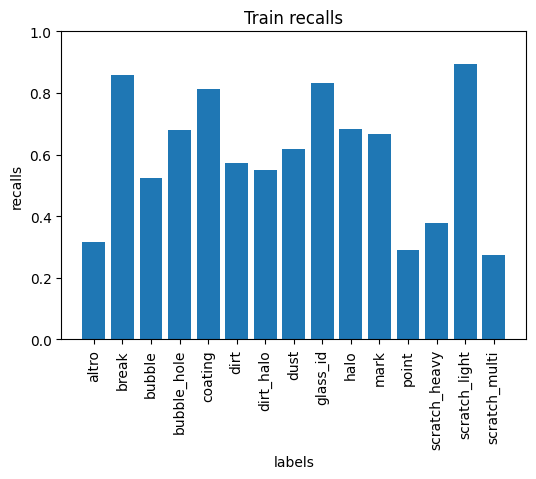

[0.3666666753590107, 0.5934959388360744, 0.4146341557909803, 0.6000000093664442, 0.7259259329901802, 0.4634146435958583, 0.6172839590796718, 0.3488372148469437, 0.794871802513416, 0.5833333416117562, 0.5528455398431639, 0.28682171328123224, 0.3076923153339288, 0.9629629643427001, 0.4017094068038158]


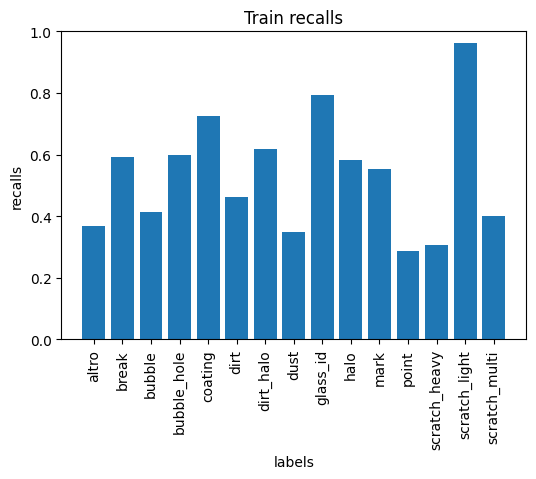

[0.3014184461629137, 0.6794871839766319, 0.4031007858209832, 0.6312056824247888, 0.8366013119618098, 0.5626911411591626, 0.577777784731653, 0.4477124269686493, 0.778846160437052, 0.6637681227663289, 0.5429553361897616, 0.3229166744276881, 0.31172840186843165, 0.8909657349653333, 0.4347826158222945]


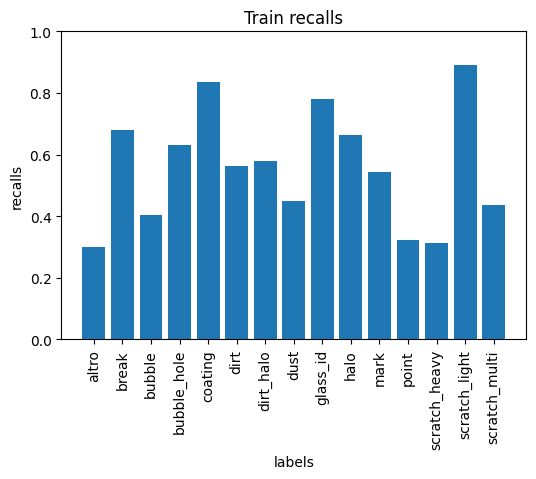

[0.3286163603078644, 0.6352201299566143, 0.4660033273756208, 0.6309523886563827, 0.806837611932021, 0.5185185283566442, 0.5437037114302318, 0.40464345658596473, 0.8518518576861689, 0.6460905422767004, 0.5609756206593862, 0.29690346903488285, 0.3468013547285639, 0.9354838731651482, 0.46869713158776916]


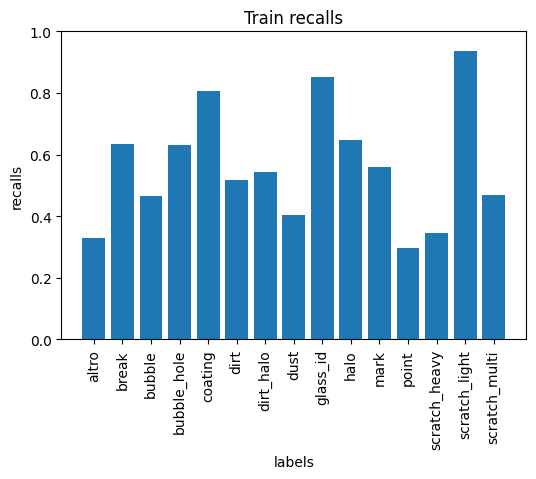

In [53]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

[0.625, 0.0, 0.7692307692307693, 0.47619047619047616, 0.95, 0.6818181818181818, 0.375, 0.5333333333333333, 0.13636363636363635, 0.38095238095238093, 0.5, 0.375, 0.5714285714285714, 0.3, 0.48]


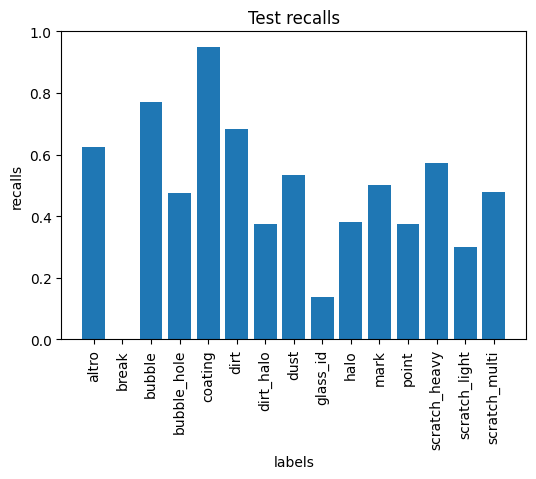

[0.4523809523809524, 0.0, 0.868421052631579, 0.7073170731707317, 0.8409090909090909, 0.5, 0.3684210526315789, 0.8085106382978723, 0.23076923076923078, 0.25, 0.6470588235294118, 0.4594594594594595, 0.5263157894736842, 0.35, 0.5319148936170213]


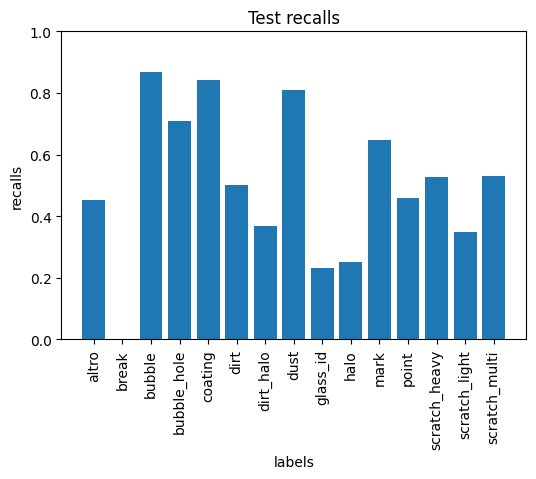

[0.5151515151515151, 0.008547008547008548, 0.8962264150943396, 0.7032967032967034, 0.72, 0.53, 0.5445544554455446, 0.7582417582417582, 0.20408163265306123, 0.3888888888888889, 0.4948453608247423, 0.4186046511627907, 0.5825242718446602, 0.46296296296296297, 0.5052631578947369]


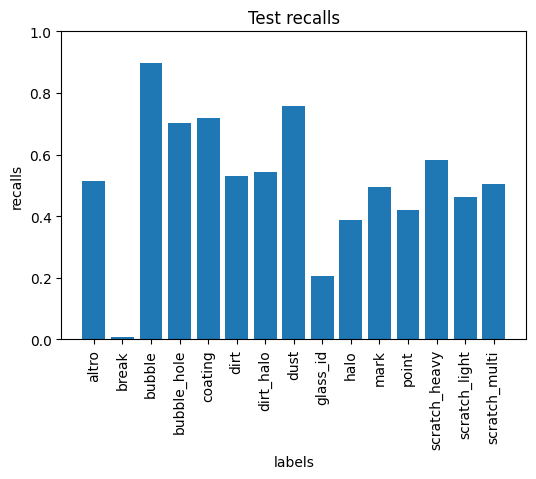

[0.4972067039106145, 0.0, 0.9259259259259259, 0.5380952380952381, 0.8, 0.5913978494623656, 0.5185185185185185, 0.8298969072164949, 0.1813186813186813, 0.3148148148148148, 0.6226415094339622, 0.3700440528634361, 0.49514563106796117, 0.3891625615763547, 0.5555555555555556]


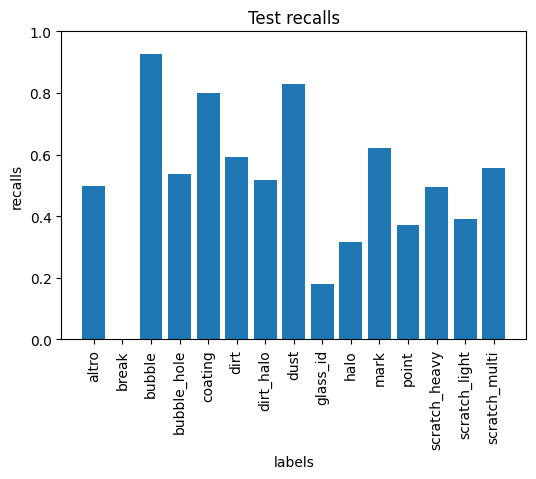

In [54]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

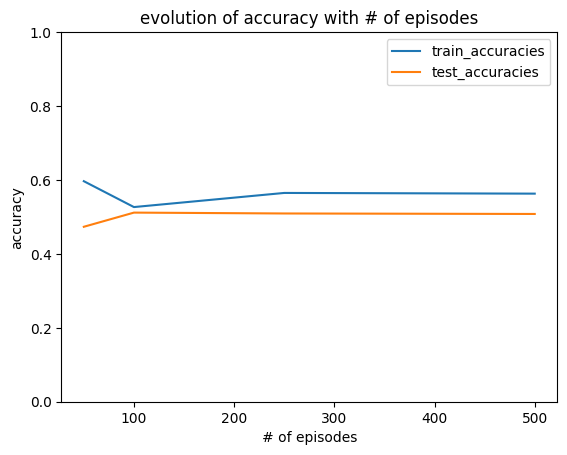

In [55]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus dataset to predict opt_bckg

In [77]:
train_images, train_images_classes, train_images_dict = extract_images('../data/views_qplus/img/')
train_images_dict = preprocess_images(train_images_dict, 23, fixed_patch_size)

In [78]:
train_classes = set(train_images_classes)
train_classes

{'altro',
 'break',
 'bubble',
 'coating',
 'dirt',
 'dust',
 'glass',
 'halo',
 'mark',
 'point',
 'scratch'}

In [79]:
train_target_classes = extend_target_classes(train_images_classes, 4)

In [80]:
test_images, test_images_classes, test_images_dict = extract_images('../data/views_opt_bckg/img/')
test_images_dict = preprocess_images(test_images_dict, 26, fixed_patch_size)

In [81]:
test_classes = set(test_images_classes)
test_classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [82]:
test_target_classes = extend_target_classes(test_images_classes, 4)

In [83]:
increased_episodes = [50, 100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

model = load_protonet_conv(
    x_dim=(3,fixed_patch_size,fixed_patch_size),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy = train(model, optimizer, train_images_dict, train_target_classes, 6,4,4, 50, episodes)
    test_accuracy_dict, test_accuracy = test(model, test_images_dict, test_target_classes, 6,4,4, episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['dust' 'altro' 'halo' 'coating' 'glass' 'dirt']
Epoch 1 -- Loss: 0.6562 Acc: 0.0117
K: ['mark' 'point' 'dust' 'bubble' 'break' 'coating']
Epoch 2 -- Loss: 1.1572 Acc: 0.0217
K: ['dust' 'coating' 'halo' 'altro' 'bubble' 'mark']
Epoch 3 -- Loss: 1.6244 Acc: 0.0333
K: ['halo' 'point' 'dust' 'break' 'altro' 'mark']
Epoch 4 -- Loss: 1.9752 Acc: 0.0450
K: ['halo' 'scratch' 'dust' 'dirt' 'glass' 'altro']
Epoch 5 -- Loss: 2.1808 Acc: 0.0592
K: ['point' 'mark' 'halo' 'altro' 'bubble' 'dirt']
Epoch 6 -- Loss: 2.6802 Acc: 0.0717
K: ['mark' 'dust' 'glass' 'altro' 'break' 'scratch']
Epoch 7 -- Loss: 2.9195 Acc: 0.0875
K: ['altro' 'point' 'glass' 'dirt' 'scratch' 'coating']
Epoch 8 -- Loss: 3.3779 Acc: 0.1000
K: ['point' 'dirt' 'halo' 'coating' 'bubble' 'altro']
Epoch 9 -- Loss: 3.5466 Acc: 0.1150
K: ['glass' 'scratch' 'dirt' 'altro' 'coating' 'bubble']
Epoch 10 -- Loss: 3.7246 Acc: 0.1300
K: ['dust' 'point' 'coating' 'halo' 'altro' 'bubble']
Epoch 11 -- Loss: 4.0377 Acc: 0.1400
K: ['mark' 'altr

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['point' 'scratch' 'background' 'break' 'dirt' 'mark']
K: ['scratch' 'mark' 'break' 'point' 'bubble' 'dirt']
K: ['bubble' 'mark' 'break' 'point' 'background' 'scratch']
K: ['dirt' 'scratch' 'bubble' 'break' 'mark' 'background']
K: ['scratch' 'point' 'break' 'mark' 'dirt' 'bubble']
K: ['background' 'break' 'dirt' 'bubble' 'mark' 'point']
K: ['background' 'mark' 'dirt' 'scratch' 'bubble' 'break']
K: ['mark' 'bubble' 'background' 'scratch' 'dirt' 'point']
K: ['point' 'dirt' 'scratch' 'background' 'mark' 'bubble']
K: ['point' 'dirt' 'bubble' 'break' 'scratch' 'background']
K: ['mark' 'scratch' 'background' 'point' 'bubble' 'break']
K: ['break' 'point' 'scratch' 'dirt' 'background' 'bubble']
K: ['bubble' 'dirt' 'mark' 'scratch' 'point' 'break']
K: ['scratch' 'break' 'bubble' 'background' 'point' 'mark']
K: ['dirt' 'break' 'point' 'bubble' 'scratch' 'background']
K: ['mark' 'point' 'scratch' 'break' 'dirt' 'background']
K: ['point' 'bubble' 'scratch' 'background' 'mark' 'dirt']
K: ['dirt'

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['altro' 'glass' 'mark' 'dust' 'halo' 'scratch']
Epoch 1 -- Loss: 0.0622 Acc: 0.0058
K: ['coating' 'break' 'altro' 'glass' 'dust' 'scratch']
Epoch 2 -- Loss: 0.1441 Acc: 0.0129
K: ['altro' 'scratch' 'coating' 'dirt' 'mark' 'glass']
Epoch 3 -- Loss: 0.2809 Acc: 0.0187
K: ['mark' 'bubble' 'scratch' 'altro' 'break' 'dust']
Epoch 4 -- Loss: 0.3947 Acc: 0.0233
K: ['dirt' 'coating' 'glass' 'altro' 'dust' 'break']
Epoch 5 -- Loss: 0.4681 Acc: 0.0308
K: ['break' 'dirt' 'halo' 'bubble' 'coating' 'point']
Epoch 6 -- Loss: 0.5638 Acc: 0.0392
K: ['halo' 'point' 'glass' 'break' 'dust' 'coating']
Epoch 7 -- Loss: 0.6120 Acc: 0.0462
K: ['dirt' 'scratch' 'mark' 'point' 'altro' 'coating']
Epoch 8 -- Loss: 0.6848 Acc: 0.0521
K: ['scratch' 'altro' 'dirt' 'glass' 'bubble' 'mark']
Epoch 9 -- Loss: 0.7809 Acc: 0.0579
K: ['halo' 'mark' 'bubble' 'break' 'dirt' 'coating']
Epoch 10 -- Loss: 0.9738 Acc: 0.0637
K: ['scratch' 'dust' 'coating' 'point' 'bubble' 'dirt']
Epoch 11 -- Loss: 1.0863 Acc: 0.0708
K: ['sc

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['background' 'mark' 'break' 'scratch' 'bubble' 'point']
K: ['point' 'mark' 'scratch' 'break' 'dirt' 'bubble']
K: ['dirt' 'scratch' 'point' 'bubble' 'break' 'background']
K: ['mark' 'point' 'bubble' 'background' 'dirt' 'break']
K: ['scratch' 'mark' 'bubble' 'background' 'break' 'dirt']
K: ['bubble' 'point' 'background' 'dirt' 'mark' 'scratch']
K: ['scratch' 'background' 'point' 'break' 'dirt' 'bubble']
K: ['point' 'mark' 'dirt' 'background' 'break' 'bubble']
K: ['point' 'background' 'scratch' 'mark' 'break' 'dirt']
K: ['bubble' 'break' 'mark' 'scratch' 'dirt' 'background']
K: ['point' 'scratch' 'dirt' 'break' 'bubble' 'background']
K: ['point' 'break' 'scratch' 'background' 'mark' 'bubble']
K: ['bubble' 'dirt' 'break' 'background' 'scratch' 'mark']
K: ['point' 'break' 'mark' 'background' 'bubble' 'scratch']
K: ['bubble' 'break' 'background' 'scratch' 'point' 'dirt']
K: ['background' 'scratch' 'dirt' 'mark' 'bubble' 'break']
K: ['break' 'background' 'scratch' 'point' 'mark' 'dirt']
K

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['dirt' 'altro' 'bubble' 'scratch' 'break' 'dust']
Epoch 1 -- Loss: 0.0091 Acc: 0.0033
K: ['dirt' 'break' 'scratch' 'mark' 'point' 'glass']
Epoch 2 -- Loss: 0.0568 Acc: 0.0063
K: ['halo' 'altro' 'coating' 'dirt' 'break' 'point']
Epoch 3 -- Loss: 0.0938 Acc: 0.0092
K: ['scratch' 'halo' 'break' 'altro' 'coating' 'mark']
Epoch 4 -- Loss: 0.1385 Acc: 0.0113
K: ['mark' 'bubble' 'coating' 'halo' 'altro' 'scratch']
Epoch 5 -- Loss: 0.2045 Acc: 0.0140
K: ['glass' 'dirt' 'break' 'mark' 'dust' 'altro']
Epoch 6 -- Loss: 0.2249 Acc: 0.0170
K: ['mark' 'halo' 'break' 'coating' 'altro' 'scratch']
Epoch 7 -- Loss: 0.3567 Acc: 0.0183
K: ['glass' 'mark' 'dirt' 'coating' 'scratch' 'point']
Epoch 8 -- Loss: 0.3823 Acc: 0.0208
K: ['halo' 'point' 'coating' 'break' 'scratch' 'glass']
Epoch 9 -- Loss: 0.4156 Acc: 0.0237
K: ['scratch' 'glass' 'mark' 'break' 'halo' 'bubble']
Epoch 10 -- Loss: 0.4465 Acc: 0.0267
K: ['halo' 'mark' 'bubble' 'dust' 'glass' 'break']
Epoch 11 -- Loss: 0.4904 Acc: 0.0288
K: ['mark'

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['mark' 'break' 'scratch' 'dirt' 'background' 'bubble']
K: ['break' 'point' 'scratch' 'dirt' 'mark' 'background']
K: ['break' 'dirt' 'scratch' 'background' 'bubble' 'mark']
K: ['point' 'dirt' 'break' 'bubble' 'background' 'scratch']
K: ['mark' 'scratch' 'point' 'break' 'background' 'bubble']
K: ['point' 'scratch' 'mark' 'background' 'dirt' 'bubble']
K: ['scratch' 'break' 'background' 'point' 'mark' 'bubble']
K: ['background' 'mark' 'scratch' 'point' 'dirt' 'break']
K: ['background' 'scratch' 'bubble' 'mark' 'point' 'dirt']
K: ['scratch' 'background' 'break' 'dirt' 'bubble' 'mark']
K: ['mark' 'bubble' 'scratch' 'background' 'dirt' 'point']
K: ['background' 'mark' 'dirt' 'break' 'scratch' 'bubble']
K: ['break' 'dirt' 'mark' 'background' 'bubble' 'point']
K: ['bubble' 'break' 'scratch' 'mark' 'background' 'point']
K: ['break' 'point' 'bubble' 'dirt' 'scratch' 'mark']
K: ['dirt' 'background' 'break' 'bubble' 'mark' 'scratch']
K: ['dirt' 'break' 'mark' 'point' 'background' 'bubble']
K: [

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['altro' 'halo' 'coating' 'dust' 'bubble' 'point']
Epoch 1 -- Loss: 0.0269 Acc: 0.0012
K: ['coating' 'altro' 'point' 'dust' 'break' 'scratch']
Epoch 2 -- Loss: 0.0492 Acc: 0.0025
K: ['break' 'glass' 'altro' 'dirt' 'bubble' 'mark']
Epoch 3 -- Loss: 0.0602 Acc: 0.0043
K: ['altro' 'glass' 'dirt' 'point' 'dust' 'break']
Epoch 4 -- Loss: 0.0778 Acc: 0.0057
K: ['dirt' 'coating' 'point' 'dust' 'halo' 'break']
Epoch 5 -- Loss: 0.0947 Acc: 0.0073
K: ['halo' 'scratch' 'glass' 'break' 'dirt' 'altro']
Epoch 6 -- Loss: 0.1107 Acc: 0.0083
K: ['point' 'altro' 'scratch' 'halo' 'coating' 'dust']
Epoch 7 -- Loss: 0.1698 Acc: 0.0090
K: ['dirt' 'halo' 'point' 'coating' 'scratch' 'bubble']
Epoch 8 -- Loss: 0.1927 Acc: 0.0101
K: ['bubble' 'scratch' 'dust' 'halo' 'coating' 'mark']
Epoch 9 -- Loss: 0.2147 Acc: 0.0113
K: ['glass' 'halo' 'dirt' 'altro' 'dust' 'mark']
Epoch 10 -- Loss: 0.2367 Acc: 0.0123
K: ['scratch' 'altro' 'bubble' 'mark' 'halo' 'point']
Epoch 11 -- Loss: 0.2443 Acc: 0.0138
K: ['halo' 'alt

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['mark' 'bubble' 'dirt' 'break' 'scratch' 'point']
K: ['dirt' 'background' 'bubble' 'point' 'scratch' 'mark']
K: ['background' 'bubble' 'break' 'dirt' 'scratch' 'mark']
K: ['break' 'mark' 'bubble' 'dirt' 'background' 'scratch']
K: ['break' 'background' 'dirt' 'scratch' 'mark' 'point']
K: ['break' 'scratch' 'point' 'mark' 'bubble' 'background']
K: ['background' 'scratch' 'dirt' 'bubble' 'mark' 'point']
K: ['bubble' 'background' 'point' 'break' 'mark' 'scratch']
K: ['point' 'break' 'bubble' 'scratch' 'dirt' 'mark']
K: ['mark' 'dirt' 'point' 'background' 'scratch' 'bubble']
K: ['mark' 'point' 'bubble' 'dirt' 'break' 'scratch']
K: ['bubble' 'mark' 'background' 'dirt' 'break' 'point']
K: ['bubble' 'point' 'background' 'dirt' 'break' 'mark']
K: ['scratch' 'bubble' 'background' 'dirt' 'mark' 'break']
K: ['dirt' 'mark' 'break' 'scratch' 'point' 'bubble']
K: ['break' 'mark' 'point' 'bubble' 'scratch' 'background']
K: ['bubble' 'background' 'mark' 'point' 'scratch' 'break']
K: ['scratch' 'bub

[0.38392857142857145, 0.9032258064516129, 0.6, 0.9482758620689655, 0.6896551724137931, 0.7241379310344828, 0.9431818181818182, 0.6521739130434783, 0.5833333333333334, 0.4583333333333333, 0.5267857142857143]


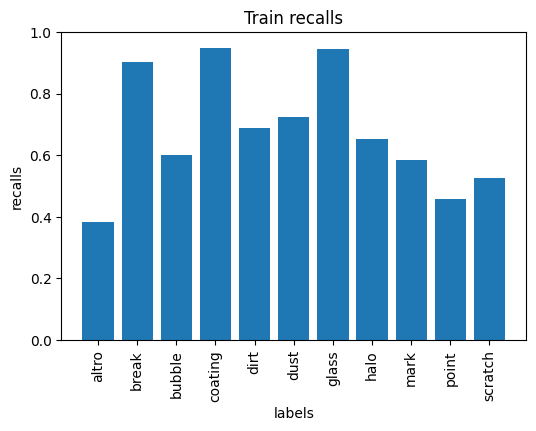

[0.33636363636363636, 0.7740384615384616, 0.6863636363636364, 0.9508196721311475, 0.5462962962962963, 0.7295918367346939, 0.8467741935483871, 0.6298076923076923, 0.615, 0.525, 0.405]


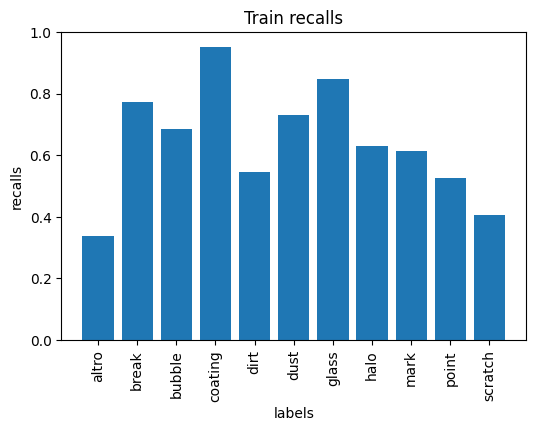

[0.35906040268456374, 0.7928571428571428, 0.6965648854961832, 0.9577702702702703, 0.5315126050420168, 0.6884328358208955, 0.8583333333333333, 0.6484375, 0.6142857142857143, 0.4521276595744681, 0.42833333333333334]


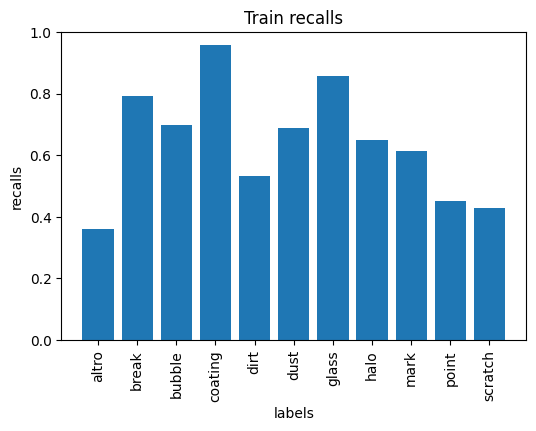

[0.3624567474048443, 0.7624521072796935, 0.6830708661417323, 0.9540441176470589, 0.5227272727272727, 0.7256554307116105, 0.8476702508960573, 0.6294014084507042, 0.5996168582375478, 0.45206766917293234, 0.4181494661921708]


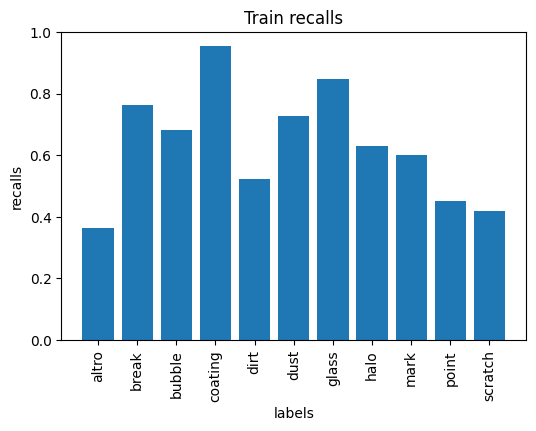

In [84]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

[0.5576923076923077, 0.75, 0.6193181818181818, 0.48255813953488375, 0.5833333333333334, 0.6666666666666666, 0.7439024390243902]


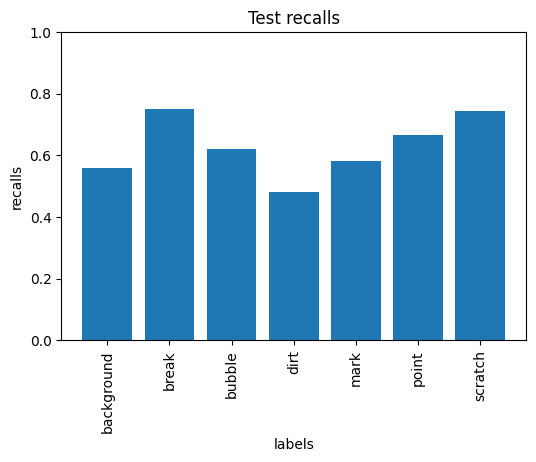

[0.5357142857142857, 0.7865853658536586, 0.6207865168539326, 0.5229885057471264, 0.6453488372093024, 0.6025641025641025, 0.6896551724137931]


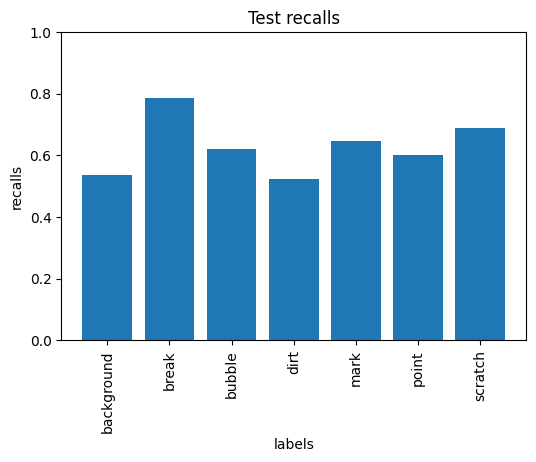

[0.6093023255813953, 0.7432126696832579, 0.613013698630137, 0.49765258215962443, 0.6156542056074766, 0.6130952380952381, 0.71875]


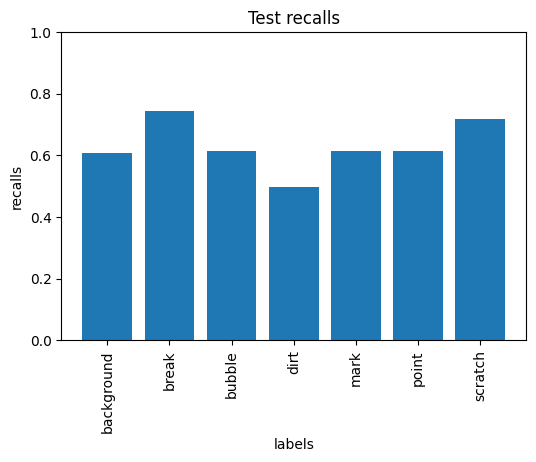

[0.6024027459954233, 0.757420091324201, 0.5941780821917808, 0.48933649289099523, 0.6402298850574712, 0.5926829268292683, 0.7071428571428572]


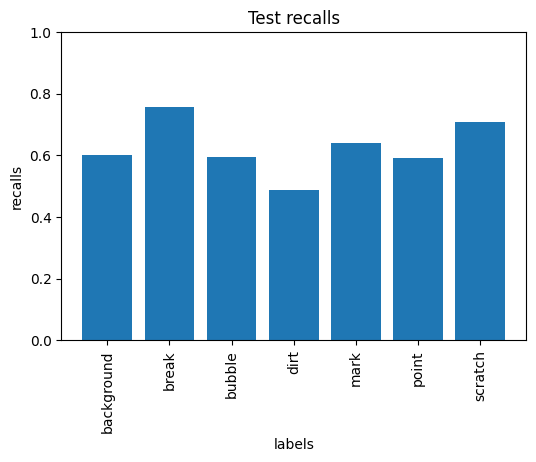

In [85]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

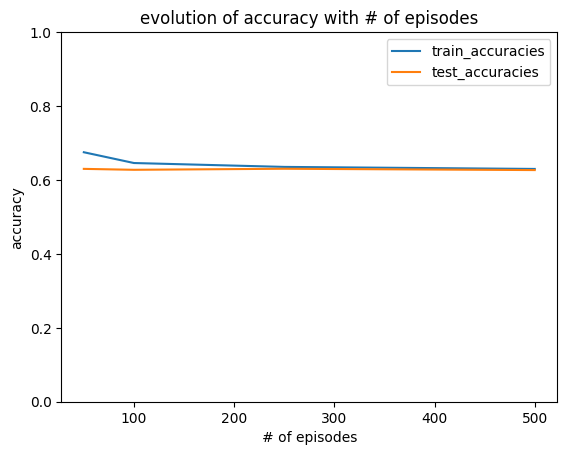

In [86]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)

# Using qplus detailed dataset to predict opt_bckg

In [87]:
train_images, train_images_classes, train_images_dict = extract_images('../data/views_qplus/img/', '_did_')
train_images_dict = preprocess_images(train_images_dict, 23, fixed_patch_size)

In [88]:
train_classes = set(train_images_classes)
train_classes

{'altro',
 'break',
 'bubble',
 'bubble_hole',
 'coating',
 'dirt',
 'dirt_halo',
 'dust',
 'glass_id',
 'halo',
 'mark',
 'point',
 'scratch_heavy',
 'scratch_light',
 'scratch_multi'}

In [89]:
train_target_classes = extend_target_classes(train_images_classes, 4)

In [90]:
test_images, test_images_classes, test_images_dict = extract_images('../data/views_opt_bckg/img/')
test_images_dict = preprocess_images(test_images_dict, 26, fixed_patch_size)

In [91]:
test_classes = set(test_images_classes)
test_classes

{'background', 'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'}

In [92]:
test_target_classes = extend_target_classes(test_images_classes, 4)

# Training and testing on different number of episodes

In [94]:
increased_episodes = [50, 100, 250, 500]
train_accuracies_dict, test_accuracies_dict = [], []
train_accuracies, test_accuracies = [], []

model = load_protonet_conv(
    x_dim=(3,fixed_patch_size,fixed_patch_size),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

for episodes in increased_episodes:
    train_accuracy_dict, train_accuracy = train(model, optimizer, train_images_dict, train_target_classes, 6,4,4, 50, episodes)
    test_accuracy_dict, test_accuracy = test(model, test_images_dict, test_target_classes, 6,4,4, episodes)
    train_accuracies_dict.append(train_accuracy_dict)
    test_accuracies_dict.append(test_accuracy_dict)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2049128832.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'bubble_hole' 'halo' 'glass_id' 'scratch_multi' 'point']
Epoch 1 -- Loss: 0.5768 Acc: 0.0133
K: ['halo' 'dirt' 'dirt_halo' 'scratch_heavy' 'scratch_light' 'scratch_multi']
Epoch 2 -- Loss: 1.5229 Acc: 0.0250
K: ['scratch_heavy' 'dirt_halo' 'bubble' 'break' 'dirt' 'bubble_hole']
Epoch 3 -- Loss: 2.1653 Acc: 0.0342
K: ['scratch_multi' 'bubble_hole' 'break' 'coating' 'glass_id'
 'scratch_heavy']
Epoch 4 -- Loss: 2.4572 Acc: 0.0450
K: ['bubble' 'dirt' 'altro' 'glass_id' 'dust' 'scratch_multi']
Epoch 5 -- Loss: 2.5980 Acc: 0.0583
K: ['scratch_light' 'dirt_halo' 'dust' 'scratch_multi' 'scratch_heavy'
 'point']
Epoch 6 -- Loss: 2.8186 Acc: 0.0692
K: ['dust' 'scratch_multi' 'dirt_halo' 'altro' 'glass_id' 'scratch_light']
Epoch 7 -- Loss: 3.2636 Acc: 0.0775
K: ['dirt' 'dirt_halo' 'scratch_multi' 'mark' 'bubble_hole' 'glass_id']
Epoch 8 -- Loss: 3.5182 Acc: 0.0925
K: ['altro' 'scratch_heavy' 'bubble_hole' 'scratch_light' 'halo' 'coating']
Epoch 9 -- Loss: 3.6705 Acc: 0.1042
K: ['scra

C:\Users\matte\AppData\Local\Temp\ipykernel_10904\2763146824.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(episodes):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'background' 'scratch' 'point' 'bubble' 'dirt']
K: ['bubble' 'mark' 'point' 'break' 'scratch' 'dirt']
K: ['point' 'dirt' 'background' 'bubble' 'break' 'scratch']
K: ['mark' 'scratch' 'break' 'dirt' 'bubble' 'point']
K: ['point' 'background' 'dirt' 'bubble' 'mark' 'break']
K: ['dirt' 'background' 'point' 'break' 'scratch' 'mark']
K: ['dirt' 'bubble' 'scratch' 'mark' 'break' 'point']
K: ['break' 'point' 'mark' 'scratch' 'bubble' 'dirt']
K: ['bubble' 'background' 'scratch' 'mark' 'point' 'break']
K: ['bubble' 'scratch' 'background' 'dirt' 'break' 'point']
K: ['scratch' 'dirt' 'bubble' 'background' 'point' 'break']
K: ['break' 'background' 'scratch' 'mark' 'point' 'dirt']
K: ['break' 'scratch' 'bubble' 'mark' 'background' 'point']
K: ['bubble' 'scratch' 'break' 'dirt' 'mark' 'background']
K: ['scratch' 'background' 'dirt' 'point' 'mark' 'break']
K: ['background' 'break' 'point' 'dirt' 'scratch' 'mark']
K: ['dirt' 'mark' 'background' 'break' 'bubble' 'point']
K: ['break' 'mark' 

Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

K: ['bubble' 'scratch_heavy' 'dirt' 'dust' 'halo' 'scratch_multi']
Epoch 1 -- Loss: 0.1566 Acc: 0.0067
K: ['dirt_halo' 'point' 'glass_id' 'halo' 'scratch_light' 'dust']
Epoch 2 -- Loss: 0.3847 Acc: 0.0113
K: ['mark' 'halo' 'dirt_halo' 'scratch_light' 'dirt' 'glass_id']
Epoch 3 -- Loss: 0.7231 Acc: 0.0171
K: ['altro' 'mark' 'dust' 'scratch_light' 'glass_id' 'scratch_multi']
Epoch 4 -- Loss: 0.8689 Acc: 0.0221
K: ['scratch_heavy' 'dirt_halo' 'point' 'glass_id' 'mark' 'dust']
Epoch 5 -- Loss: 1.2372 Acc: 0.0262
K: ['dirt' 'break' 'mark' 'scratch_light' 'glass_id' 'altro']
Epoch 6 -- Loss: 1.3737 Acc: 0.0325
K: ['altro' 'dirt' 'coating' 'halo' 'bubble_hole' 'dirt_halo']
Epoch 7 -- Loss: 1.4898 Acc: 0.0383
K: ['bubble_hole' 'break' 'scratch_multi' 'scratch_heavy' 'coating' 'point']
Epoch 8 -- Loss: 1.5955 Acc: 0.0421
K: ['glass_id' 'bubble' 'point' 'mark' 'altro' 'dirt']
Epoch 9 -- Loss: 1.8289 Acc: 0.0467
K: ['halo' 'scratch_light' 'dirt' 'mark' 'scratch_multi' 'bubble_hole']
Epoch 10 -- L

  0%|          | 0/100 [00:00<?, ?it/s]

K: ['bubble' 'break' 'mark' 'point' 'scratch' 'dirt']
K: ['mark' 'background' 'scratch' 'bubble' 'dirt' 'break']
K: ['bubble' 'scratch' 'mark' 'background' 'dirt' 'break']
K: ['background' 'point' 'mark' 'break' 'dirt' 'scratch']
K: ['point' 'break' 'background' 'dirt' 'mark' 'scratch']
K: ['mark' 'scratch' 'break' 'bubble' 'point' 'background']
K: ['point' 'mark' 'scratch' 'background' 'bubble' 'break']
K: ['break' 'mark' 'point' 'bubble' 'dirt' 'background']
K: ['dirt' 'background' 'break' 'point' 'mark' 'scratch']
K: ['break' 'mark' 'dirt' 'bubble' 'background' 'point']
K: ['point' 'mark' 'background' 'scratch' 'bubble' 'break']
K: ['break' 'background' 'mark' 'bubble' 'point' 'scratch']
K: ['scratch' 'dirt' 'bubble' 'background' 'point' 'mark']
K: ['break' 'dirt' 'scratch' 'bubble' 'point' 'mark']
K: ['mark' 'dirt' 'background' 'bubble' 'point' 'break']
K: ['dirt' 'mark' 'point' 'background' 'break' 'bubble']
K: ['break' 'mark' 'background' 'point' 'bubble' 'scratch']
K: ['dirt' 'b

Epoch 1 train:   0%|          | 0/250 [00:00<?, ?it/s]

K: ['dirt' 'dirt_halo' 'mark' 'bubble_hole' 'scratch_multi' 'glass_id']
Epoch 1 -- Loss: 0.0199 Acc: 0.0028
K: ['dirt_halo' 'dust' 'scratch_multi' 'glass_id' 'scratch_light' 'point']
Epoch 2 -- Loss: 0.0639 Acc: 0.0050
K: ['coating' 'break' 'bubble' 'dirt' 'dust' 'halo']
Epoch 3 -- Loss: 0.0970 Acc: 0.0073
K: ['dirt' 'dust' 'glass_id' 'coating' 'point' 'halo']
Epoch 4 -- Loss: 0.1779 Acc: 0.0092
K: ['scratch_multi' 'scratch_light' 'bubble' 'altro' 'dirt' 'dirt_halo']
Epoch 5 -- Loss: 0.2017 Acc: 0.0118
K: ['mark' 'scratch_multi' 'dirt_halo' 'dirt' 'dust' 'break']
Epoch 6 -- Loss: 0.2607 Acc: 0.0145
K: ['break' 'altro' 'scratch_light' 'halo' 'dirt_halo' 'dirt']
Epoch 7 -- Loss: 0.3144 Acc: 0.0168
K: ['dirt_halo' 'mark' 'altro' 'bubble_hole' 'scratch_heavy' 'scratch_multi']
Epoch 8 -- Loss: 0.3407 Acc: 0.0198
K: ['break' 'dust' 'scratch_heavy' 'dirt' 'bubble' 'glass_id']
Epoch 9 -- Loss: 0.4115 Acc: 0.0223
K: ['halo' 'glass_id' 'dust' 'bubble' 'coating' 'dirt_halo']
Epoch 10 -- Loss: 0.4

  0%|          | 0/250 [00:00<?, ?it/s]

K: ['mark' 'dirt' 'point' 'scratch' 'break' 'background']
K: ['scratch' 'dirt' 'point' 'break' 'bubble' 'mark']
K: ['dirt' 'point' 'bubble' 'scratch' 'background' 'break']
K: ['break' 'background' 'point' 'bubble' 'mark' 'dirt']
K: ['background' 'break' 'dirt' 'point' 'bubble' 'scratch']
K: ['point' 'break' 'mark' 'dirt' 'background' 'scratch']
K: ['dirt' 'break' 'mark' 'bubble' 'point' 'scratch']
K: ['bubble' 'point' 'break' 'mark' 'dirt' 'scratch']
K: ['background' 'point' 'break' 'mark' 'dirt' 'scratch']
K: ['dirt' 'break' 'scratch' 'mark' 'bubble' 'background']
K: ['scratch' 'bubble' 'break' 'dirt' 'point' 'background']
K: ['point' 'scratch' 'mark' 'break' 'background' 'dirt']
K: ['break' 'dirt' 'background' 'scratch' 'bubble' 'mark']
K: ['break' 'scratch' 'background' 'dirt' 'mark' 'bubble']
K: ['scratch' 'background' 'dirt' 'point' 'mark' 'break']
K: ['background' 'break' 'mark' 'dirt' 'point' 'bubble']
K: ['scratch' 'point' 'dirt' 'break' 'background' 'bubble']
K: ['scratch' 'po

Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

K: ['halo' 'mark' 'point' 'glass_id' 'scratch_light' 'break']
Epoch 1 -- Loss: 0.0385 Acc: 0.0012
K: ['dirt_halo' 'coating' 'break' 'scratch_light' 'scratch_multi' 'point']
Epoch 2 -- Loss: 0.0546 Acc: 0.0022
K: ['dust' 'break' 'scratch_multi' 'scratch_light' 'glass_id' 'halo']
Epoch 3 -- Loss: 0.0613 Acc: 0.0036
K: ['scratch_light' 'coating' 'glass_id' 'break' 'scratch_multi' 'bubble']
Epoch 4 -- Loss: 0.0969 Acc: 0.0046
K: ['bubble' 'bubble_hole' 'altro' 'dust' 'mark' 'scratch_light']
Epoch 5 -- Loss: 0.1217 Acc: 0.0057
K: ['break' 'point' 'dirt' 'altro' 'scratch_heavy' 'mark']
Epoch 6 -- Loss: 0.1472 Acc: 0.0067
K: ['scratch_light' 'point' 'scratch_heavy' 'dirt_halo' 'dust' 'break']
Epoch 7 -- Loss: 0.1897 Acc: 0.0077
K: ['dirt_halo' 'scratch_light' 'glass_id' 'mark' 'bubble' 'halo']
Epoch 8 -- Loss: 0.2005 Acc: 0.0092
K: ['halo' 'mark' 'point' 'bubble_hole' 'scratch_heavy' 'dirt_halo']
Epoch 9 -- Loss: 0.2729 Acc: 0.0101
K: ['scratch_heavy' 'scratch_light' 'point' 'halo' 'break' 'd

  0%|          | 0/500 [00:00<?, ?it/s]

K: ['mark' 'scratch' 'point' 'background' 'dirt' 'break']
K: ['point' 'dirt' 'scratch' 'bubble' 'background' 'mark']
K: ['bubble' 'mark' 'scratch' 'break' 'dirt' 'point']
K: ['mark' 'point' 'scratch' 'background' 'break' 'bubble']
K: ['bubble' 'mark' 'background' 'scratch' 'point' 'dirt']
K: ['bubble' 'scratch' 'mark' 'background' 'dirt' 'point']
K: ['break' 'background' 'point' 'dirt' 'scratch' 'mark']
K: ['bubble' 'break' 'scratch' 'mark' 'dirt' 'point']
K: ['mark' 'bubble' 'point' 'dirt' 'background' 'break']
K: ['mark' 'dirt' 'bubble' 'background' 'point' 'break']
K: ['point' 'scratch' 'dirt' 'break' 'mark' 'bubble']
K: ['break' 'mark' 'dirt' 'background' 'bubble' 'point']
K: ['dirt' 'scratch' 'point' 'break' 'background' 'mark']
K: ['break' 'scratch' 'bubble' 'mark' 'point' 'background']
K: ['mark' 'break' 'background' 'bubble' 'dirt' 'scratch']
K: ['point' 'break' 'dirt' 'bubble' 'mark' 'scratch']
K: ['bubble' 'point' 'mark' 'dirt' 'background' 'scratch']
K: ['dirt' 'break' 'poin

[0.3181818181818182, 0.7395833333333334, 0.4342105263157895, 0.5972222222222222, 0.85, 0.5714285714285714, 0.7282608695652174, 0.765625, 0.6931818181818182, 0.55, 0.6309523809523809, 0.2875, 0.4673913043478261, 0.5113636363636364, 0.5]


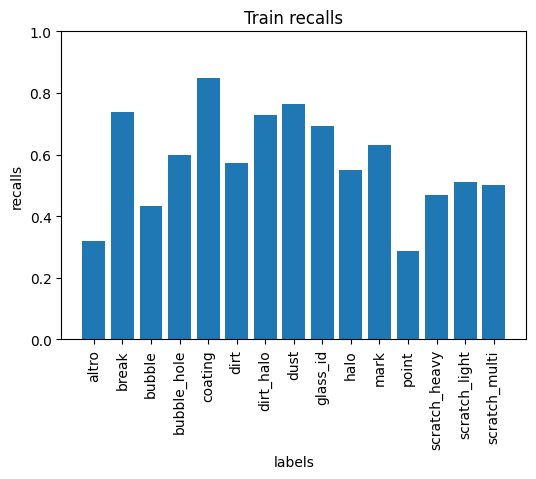

[0.3829787234042553, 0.8382352941176471, 0.5, 0.46296296296296297, 0.8125, 0.5294117647058824, 0.5697674418604651, 0.5760869565217391, 0.7, 0.5608108108108109, 0.625, 0.3273809523809524, 0.43125, 0.6351351351351351, 0.5]


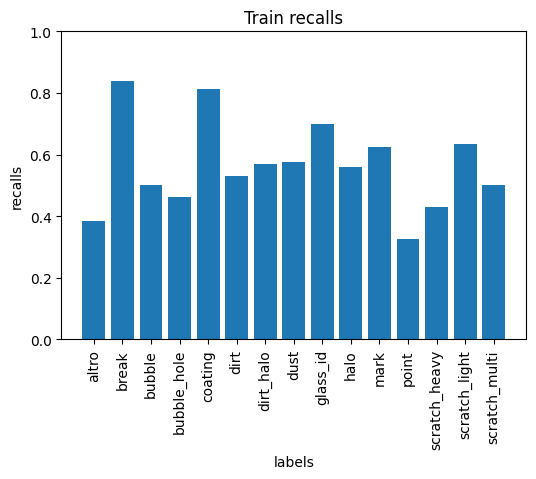

[0.3179347826086957, 0.7568181818181818, 0.5515463917525774, 0.4690721649484536, 0.8055555555555556, 0.5747422680412371, 0.5789473684210527, 0.6004901960784313, 0.7066326530612245, 0.6177884615384616, 0.5986842105263158, 0.3118279569892473, 0.42475728155339804, 0.7117346938775511, 0.5321782178217822]


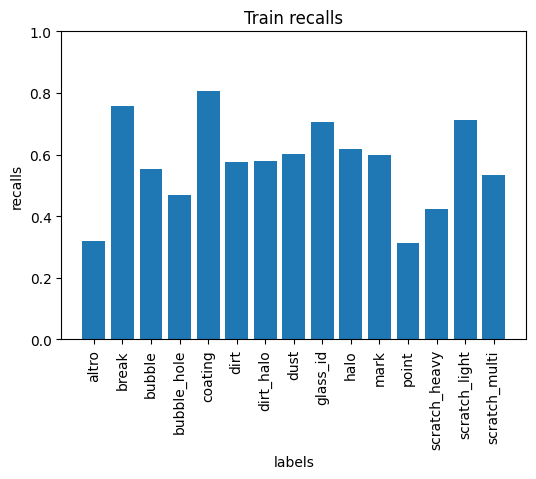

[0.3686635944700461, 0.75, 0.5625, 0.5024875621890548, 0.7779017857142857, 0.5740740740740741, 0.5348258706467661, 0.6244019138755981, 0.7023195876288659, 0.5601092896174863, 0.6175, 0.308411214953271, 0.4517766497461929, 0.6982323232323232, 0.47580645161290325]


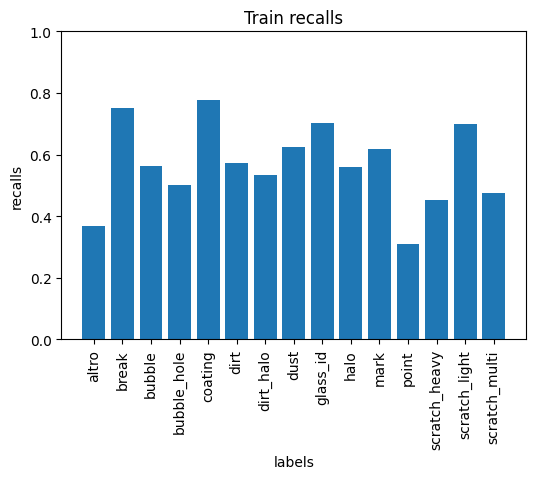

In [95]:
plot_accuracies_dict(train_accuracies_dict, 'Train recalls')

[0.5535714285714286, 0.7391304347826086, 0.5, 0.4127906976744186, 0.6375, 0.5056818181818182, 0.6195652173913043]


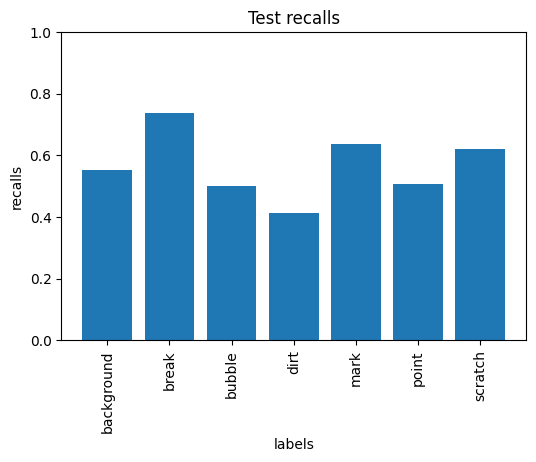

[0.5670731707317073, 0.8095238095238095, 0.5638888888888889, 0.3879310344827586, 0.6982758620689655, 0.5297619047619048, 0.5843023255813954]


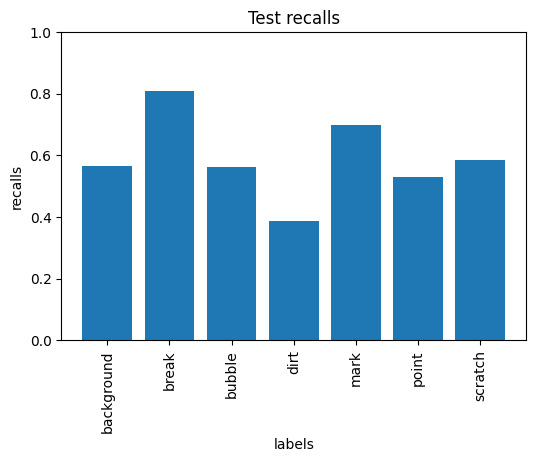

[0.6315165876777251, 0.8154761904761905, 0.5142543859649122, 0.4197674418604651, 0.6165865384615384, 0.5502283105022832, 0.5801435406698564]


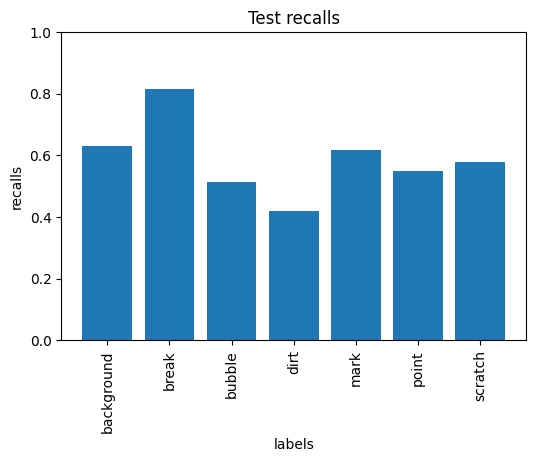

[0.6189931350114416, 0.8090596330275229, 0.49117647058823527, 0.45, 0.6519495412844036, 0.5277108433734939, 0.5880281690140845]


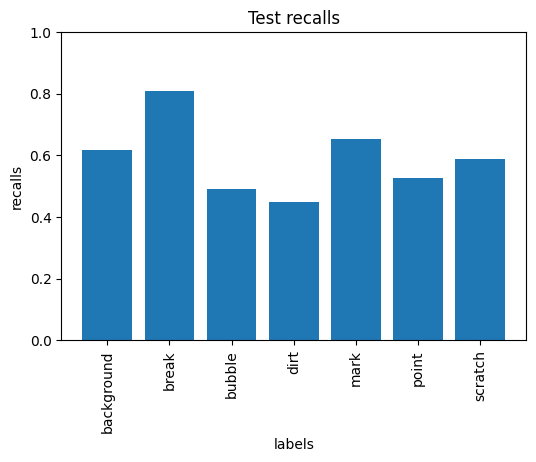

In [96]:
plot_accuracies_dict(test_accuracies_dict, 'Test recalls')

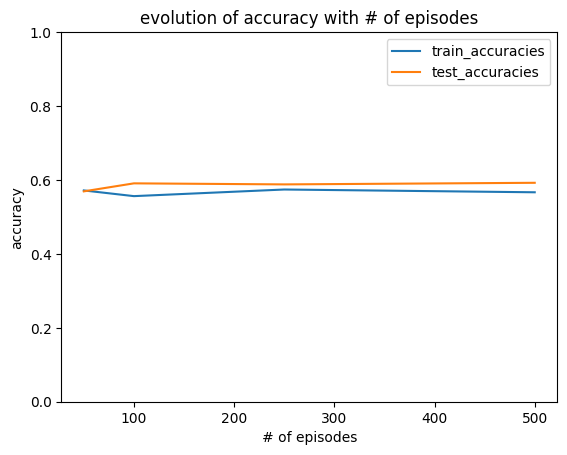

In [97]:
plot_accuracies(episodes_list, train_accuracies, test_accuracies)